In [9]:
import os
import numpy as np
import pymatgen as mg
import pandas as pd
from pymatgen.core import Structure
from figrecipes import PlotlyFig
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from pymatgen.core.periodic_table import Element
from pymatgen.analysis.local_env import CrystalNN
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition.alloy import Miedema
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import OxidationStates
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition.thermo import CohesiveEnergy
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Prepare Data

## 495 SQS(8 atoms)

### young's modulus

In [2]:
os.chdir('/home/zhaoxi/elastic_HEC/structure/structure')

In [3]:
vasp_list=os.listdir()[1:]
vasp_list.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list)

['0.vasp', '1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp', '41.vasp', '42.vasp', '43.vasp', '44.vasp', '45.vasp', '46.vasp', '47.vasp', '48.vasp', '49.vasp', '50.vasp', '51.vasp', '52.vasp', '53.vasp', '54.vasp', '55.vasp', '56.vasp', '57.vasp', '58.vasp', '59.vasp', '60.vasp', '61.vasp', '62.vasp', '63.vasp', '64.vasp', '65.vasp', '66.vasp', '67.vasp', '68.vasp', '69.vasp', '70.vasp', '71.vasp', '72.vasp', '73.vasp', '74.vasp', '75.vasp', '76.vasp', '77.vasp', '78.vasp', '79.vasp', '80.vasp', '81.vasp', '82.vasp', '83.vasp', '84.vasp', '85.vasp', '86.vasp', '87.vasp', '88.vasp', '89.vasp', '90.vasp', '91.vasp

In [4]:
len(vasp_list)

715

In [5]:
structs = []
modulus = []
for i in vasp_list:
    structs.append(Structure.from_file(i))
    with open(i) as f:
        lines = f.readlines()
        modulus.append(float(lines[0].split('|')[4]))

In [6]:
df_modulus = pd.DataFrame()
formula=[]
for i in structs:
    formula.append(i.formula)
df_modulus["formula"]=formula
df_modulus["structure"]=structs
df_modulus["young_modulus"]=modulus

In [7]:
### bulk moludus
os.chdir('/home/zhaoxi/elastic_HEC/structure/Bulk')

In [8]:
vasp_list_bulk=os.listdir()[0:]
vasp_list_bulk.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list_bulk)

['0.vasp', '1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp', '41.vasp', '42.vasp', '43.vasp', '44.vasp', '45.vasp', '46.vasp', '47.vasp', '48.vasp', '49.vasp', '50.vasp', '51.vasp', '52.vasp', '53.vasp', '54.vasp', '55.vasp', '56.vasp', '57.vasp', '58.vasp', '59.vasp', '60.vasp', '61.vasp', '62.vasp', '63.vasp', '64.vasp', '65.vasp', '66.vasp', '67.vasp', '68.vasp', '69.vasp', '70.vasp', '71.vasp', '72.vasp', '73.vasp', '74.vasp', '75.vasp', '76.vasp', '77.vasp', '78.vasp', '79.vasp', '80.vasp', '81.vasp', '82.vasp', '83.vasp', '84.vasp', '85.vasp', '86.vasp', '87.vasp', '88.vasp', '89.vasp', '90.vasp', '91.vasp

In [9]:
bulk_modulus = []
for i in vasp_list_bulk:
    with open(i) as f:
        lines = f.readlines()
        bulk_modulus.append(float(lines[0].split('|')[4]))
        
df_modulus["bulk_modulus"]=bulk_modulus

### Shear modulus

In [10]:
os.chdir('/home/zhaoxi/elastic_HEC/structure/Shear')

In [11]:
vasp_list_shear=os.listdir()[0:]
vasp_list_shear.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list_shear)

['0.vasp', '1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp', '41.vasp', '42.vasp', '43.vasp', '44.vasp', '45.vasp', '46.vasp', '47.vasp', '48.vasp', '49.vasp', '50.vasp', '51.vasp', '52.vasp', '53.vasp', '54.vasp', '55.vasp', '56.vasp', '57.vasp', '58.vasp', '59.vasp', '60.vasp', '61.vasp', '62.vasp', '63.vasp', '64.vasp', '65.vasp', '66.vasp', '67.vasp', '68.vasp', '69.vasp', '70.vasp', '71.vasp', '72.vasp', '73.vasp', '74.vasp', '75.vasp', '76.vasp', '77.vasp', '78.vasp', '79.vasp', '80.vasp', '81.vasp', '82.vasp', '83.vasp', '84.vasp', '85.vasp', '86.vasp', '87.vasp', '88.vasp', '89.vasp', '90.vasp', '91.vasp

In [12]:
shear_modulus = []
for i in vasp_list_shear:
    with open(i) as f:
        lines = f.readlines()
        shear_modulus.append(float(lines[0].split('|')[4]))
        
df_modulus["shear_modulus"]=shear_modulus

In [13]:
os.chdir('/home/zhaoxi/elastic_HEC/structure/hardness')

In [14]:
vasp_list_hardness=os.listdir()[0:]
vasp_list_hardness.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list_hardness)

['0.vasp', '1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp', '41.vasp', '42.vasp', '43.vasp', '44.vasp', '45.vasp', '46.vasp', '47.vasp', '48.vasp', '49.vasp', '50.vasp', '51.vasp', '52.vasp', '53.vasp', '54.vasp', '55.vasp', '56.vasp', '57.vasp', '58.vasp', '59.vasp', '60.vasp', '61.vasp', '62.vasp', '63.vasp', '64.vasp', '65.vasp', '66.vasp', '67.vasp', '68.vasp', '69.vasp', '70.vasp', '71.vasp', '72.vasp', '73.vasp', '74.vasp', '75.vasp', '76.vasp', '77.vasp', '78.vasp', '79.vasp', '80.vasp', '81.vasp', '82.vasp', '83.vasp', '84.vasp', '85.vasp', '86.vasp', '87.vasp', '88.vasp', '89.vasp', '90.vasp', '91.vasp

In [15]:
hardness = []
for i in vasp_list_hardness:
    with open(i) as f:
        lines = f.readlines()
        hardness.append(float(lines[0].split('|')[4]))
        
df_modulus["hardness"]=hardness

In [17]:
df_modulus

formula                                          structure  \
0            Hf1 Cr3 C4  [[0.        2.1250038 0.       ] C, [2.1250038...   
1            Cr3 Mo1 C4  [[0.         2.08341687 0.        ] C, [2.0834...   
2        Hf1 Cr2 Mo1 C4  [[0.        2.1643608 0.       ] C, [2.1555275...   
3        Ta1 Cr1 Si2 C4  [[0.         2.07545584 0.        ] C, [2.0754...   
4        Ti1 Cr1 Si2 C4  [[0.         2.03121598 0.        ] C, [2.0312...   
..                  ...                                                ...   
710  Hf1 Zr1 Ti1 Mo1 C4  [[0.         2.26051069 0.        ] C, [2.2507...   
711   Hf1 Zr1 Ti1 W1 C4  [[0.        2.2579031 0.       ] C, [2.2486180...   
712  Hf1 Zr1 Ti1 Cr1 C4  [[0.         2.24314281 0.        ] C, [2.2209...   
713  Hf1 Zr1 Ti1 Si1 C4  [[0.         2.26081511 0.        ] C, [2.2420...   
714   Hf1 Zr1 Mo1 W1 C4  [[0.         2.26225962 0.        ] C, [2.2394...   

     young_modulus  bulk_modulus  shear_modulus  hardness  
0          389.372       288.436        152.694    14.870  
1          415.446       335.457        160.578    13.364  
2          405.053       296.660        159.164    15.595  
3          409.741       252.155        166.673    21.363  
4          434.640       242.592        180.890    26.409  
..             ...           ...            ...       ...  
710        447.043       264.227        183.513    24.300  
711        466.460       275.254        191.556    25.057  
712        399.981       244.938        162.881    21.208  
713        363.029       216.755        148.677    20.798  
714        468.513       292.300        190.011    22.790  

[715 rows x 6 columns]

### 495种不含Si的结构

In [18]:
df_modulus_no_Si = df_modulus[~ df_modulus['formula'].str.contains('Si')]

In [19]:
df_modulus_no_Si

formula                                          structure  \
0            Hf1 Cr3 C4  [[0.        2.1250038 0.       ] C, [2.1250038...   
1            Cr3 Mo1 C4  [[0.         2.08341687 0.        ] C, [2.0834...   
2        Hf1 Cr2 Mo1 C4  [[0.        2.1643608 0.       ] C, [2.1555275...   
13       Hf1 Nb1 Cr2 C4  [[0.         2.18573619 0.        ] C, [2.1667...   
14           Ta3 Cr1 C4  [[0.         2.20279724 0.        ] C, [2.2027...   
..                  ...                                                ...   
708  Hf1 Zr1 Nb1 Cr1 C4  [[0.         2.25773673 0.        ] C, [2.2408...   
710  Hf1 Zr1 Ti1 Mo1 C4  [[0.         2.26051069 0.        ] C, [2.2507...   
711   Hf1 Zr1 Ti1 W1 C4  [[0.        2.2579031 0.       ] C, [2.2486180...   
712  Hf1 Zr1 Ti1 Cr1 C4  [[0.         2.24314281 0.        ] C, [2.2209...   
714   Hf1 Zr1 Mo1 W1 C4  [[0.         2.26225962 0.        ] C, [2.2394...   

     young_modulus  bulk_modulus  shear_modulus  hardness  
0          389.372       288.436        152.694    14.870  
1          415.446       335.457        160.578    13.364  
2          405.053       296.660        159.164    15.595  
13         424.355       277.584        170.395    19.639  
14         497.590       328.912        199.377    21.448  
..             ...           ...            ...       ...  
708        428.202       258.681        174.903    22.728  
710        447.043       264.227        183.513    24.300  
711        466.460       275.254        191.556    25.057  
712        399.981       244.938        162.881    21.208  
714        468.513       292.300        190.011    22.790  

[495 rows x 6 columns]

In [20]:
df_young = pd.DataFrame()
df_bulk = pd.DataFrame()
df_shear = pd.DataFrame()
df_hardness = pd.DataFrame()

df_young["formula"] = df_modulus_no_Si["formula"]
df_young["young_modulus"] = df_modulus_no_Si["young_modulus"]

df_bulk["formula"] = df_modulus_no_Si["formula"]
df_bulk["bulk_modulus"] = df_modulus_no_Si["bulk_modulus"]

df_shear["formula"] = df_modulus_no_Si["formula"]
df_shear["shear_modulus"] = df_modulus_no_Si["shear_modulus"]

df_hardness["formula"] = df_modulus_no_Si["formula"]
df_hardness["hardness"] = df_modulus_no_Si["hardness"]

### Save data

In [21]:
df_modulus_no_Si.to_csv("/home/zhaoxi/Data/all_elasticity.csv",index=False)
df_young.to_csv("/home/zhaoxi/Data/young.csv",index=False)
df_bulk.to_csv("/home/zhaoxi/Data/bulk.csv",index=False)
df_shear.to_csv("/home/zhaoxi/Data/shear.csv",index=False)
df_hardness.to_csv("/home/zhaoxi/Data/hardness.csv",index=False)

# Funtion

# Features Engineering

In [22]:
#### data process 添加特征
def data_process(df):
    df=StrToComposition().featurize_dataframe(df,"formula")
    ep_feat= ElementProperty.from_preset(preset_name="magpie")
    df=ep_feat.featurize_dataframe(df,col_id="composition")
    df=CompositionToOxidComposition().featurize_dataframe(df,"composition")
    os_feat = OxidationStates()
    df=os_feat.featurize_dataframe(df,col_id="composition_oxid")
    df_feat = DensityFeatures()
    df=df_feat.featurize_dataframe(df,"structure")
    
    return df

In [23]:
#### 标准化处理
def standardization(x):
    scaler = StandardScaler()
    scaler.fit(x)
    X = scaler.transform(x)
    return X

In [24]:
## random forest & compute cross validation scores for random forest model#  交叉验证

def rf_cross_validation(x,y):
        #Try a random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(x, y)

    print('training R2 = ' + str(round(rf.score(x, y), 3)))
    print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(x))))
    print('training MAE = %.3f' % mean_absolute_error(y_true=y, y_pred=rf.predict(x)))
    
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    r2_scores = cross_val_score(rf, x, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
    mae_scores = cross_val_score(rf, x, y, scoring='neg_mean_absolute_error', cv=crossvalidation, n_jobs=-1)
    scores = cross_val_score(rf, x, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
    rmse_scores = [np.sqrt(abs(s)) for s in scores]

    print('Cross-validation results:')
    print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
    print('Folds: %i, mean MAE: %.3f' % (len(scores), np.mean(np.abs(mae_scores))))
    print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

In [25]:
#### 测试集误差
def rf_test(x,y,df):
    x['formula'] = df['formula']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) 
    train_formula = x_train['formula']
    x_train = x_train.drop('formula', axis=1)
    test_formula = x_test['formula']
    x_test = x_test.drop('formula', axis=1)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(x_train, y_train)

# get fit statistics
    print('training R2 = ' + str(round(rf_reg.score(x_train, y_train), 3)))
    print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf_reg.predict(x_train))))
    print('training MAE = %.3f' %  mean_absolute_error(y_true=y_train, y_pred=rf_reg.predict(x_train)))
    print('test R2 = ' + str(round(rf_reg.score(x_test, y_test), 3)))
    print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_reg.predict(x_test))))
    print('test MAE = %.3f' % mean_absolute_error(y_true=y_test, y_pred=rf_reg.predict(x_test)))

In [26]:
#### 预测精度随样本数据变化的大小
def calc_learning_curve(x,y,estimator):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, x, y,scoring='neg_mean_absolute_error', cv=cv, train_sizes=[0.1,0.2, 0.4, 0.6, 0.8,1])
    test_scores_mean = np.mean(test_scores, axis=1)* -1
    
       
    # plot_learning_curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, test_scores_mean, 'o-',linewidth=1.5, color="r", label="Young's modulus") ### train_scores每组数据进行训练后的算法训练得分。
    plt.legend(loc ="best", fontsize = 16)
    plt.tick_params(labelsize = 12) 
    plt.xlabel("Training examples",fontsize = 14)
    plt.ylabel("Mean Absolute Error(eV)",fontsize = 14)
    plt.tick_params(left='on',bottom='on',direction='in')
#    plt.title("Learning Curves",fontsize = 14)
#    plt.savefig('/mnt/e/ZHAO/Data/MAE.png', dpi = 600, bbox_inches = 'tight')
    
    plt.title("Learning Curves",fontsize = 14)
    plt.show()

In [27]:
def calc_obs_vs_pred(x, y, estimator, test_size=0.2):
    '''
    The observation vs prediction plot
    '''
    df = pd.DataFrame(columns=['train_truth', 'train_predict', 'test_truth', 'test_predict'])
    x_train, x_test, y_train, y_test = \
            train_test_split(x, y, test_size=test_size, random_state=1)
    estimator.fit(x_train, y_train)
    
    df['train_truth'] = y_train
    df['train_predict'] = estimator.predict(x_train)
    df['test_truth'] = pd.Series(y_test)
    df['test_predict'] = pd.Series(estimator.predict(x_test))
    
    
    return df

In [28]:
def plot_obs_vs_pred(df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    sns.set(style="ticks",font_scale=1.7)
   
   ###### first figure
    #ax.text(-0.15, -0.1, '(a)', transform=ax.transAxes, size=16)
    
    axesSub = sns.scatterplot(x= 'train_predict', y='train_truth', s=220, marker='o',  data = df,alpha = 0.7, color = 'b',ax=axs[0])
    formatXy = 'y = x'
    axs[0].plot((0, 1.2),(0, 1.2), transform=axs[0].transAxes, linewidth=3, ls='--',c='k',alpha=0.6, label = formatXy)
    
    #######定义标签
    train_test = df['train_truth'].to_numpy()
    train_pred =  df['train_predict'].to_numpy()
    
    xy_mse = np.sum((train_pred-train_test)**2);
    xy_mean = np.mean(train_pred);
    xx_mean = np.sum((train_pred - xy_mean)**2);
    #R2 = 1 - xy_mse/xx_mean
    R = np.sqrt(1 - xy_mse/xx_mean)
    MAE = np.mean(np.abs(train_pred - train_test))
    RMSE = np.sqrt(np.mean((train_pred - train_test)**2))
    str_R1 = 'R = %.3f \nRMSE = %.3f \nMAE = %.3f '%(R, RMSE, MAE)
        

#    axs[0].tick_params(labelsize=14)
    
    ###### second figure
 
    axesSub = sns.scatterplot(x= 'test_predict', y='test_truth', s=220,marker='o',  data = df,alpha = 0.7, color = 'b',ax=axs[1])
    formatXy = 'y = x'
    axs[1].plot((0, 1.2),(0, 1.2), transform=axs[1].transAxes, linewidth=3, ls='--',c='k',alpha=0.6, label = formatXy)
#    axs[1].tick_params(labelsize=14)
    str_R2 = "R = 0.888 \nRMSE = 17.099 \nMAE = 12.276"   ## 495组数据R，RMSE,MAE

    axs[0].set_xlim(300,560)
    axs[0].set_ylim(300,560)
    axs[0].set(xlabel='Train ground truth (eV)',
           ylabel='Prediction (eV)')
    axs[0].text(360,540,str_R1,fontsize = 16)
    axs[0].tick_params(left='on',bottom='on',direction='in')
    
    axs[1].set_xlim(300,580)
    axs[1].set_ylim(300,580)
    axs[1].set(xlabel='Test ground truth (eV)',
           ylabel='Prediction (eV)')
    axs[1].text(350,540,str_R2,fontsize = 16)
    axs[1].tick_params(left='on',bottom='on',direction='in')
    
    fig.subplots_adjust(wspace=0.2)
    
    
    return

In [29]:
# 绘制预测值与真实值之间的散点图
def calc_pred_curve(x, y):
    dataset1 = pd.DataFrame()
    rf.fit(x, y)
    y_pred=rf.predict(x)
    dataset1["y_pred"] = y_pred
    dataset1["y_test"] = y

    sns.set(style="white", font_scale=1.5,color_codes=True)

    pred_min, pred_max = dataset1['y_pred'].min(),dataset1['y_pred'].max()
    true_min, true_max = dataset1['y_test'].min(),dataset1['y_test'].max()

    y_pred  = dataset1['y_test'].to_numpy()
    y_test =  dataset1['y_pred'].to_numpy()

    xy_mse = np.sum((y_pred-y_test)**2);
    xy_mean = np.mean(y_pred);
    xx_mean = np.sum((y_pred - xy_mean)**2);
    #R2 = 1 - xy_mse/xx_mean
    R = np.sqrt(1 - xy_mse/xx_mean)
    MAE = np.mean(np.abs(y_pred - y_test))
    RMSE = np.sqrt(np.mean((y_pred - y_test)**2))

    p = np.polyfit(y_pred, y_test, 1)

    #formatSpec = 'y = %.3fx+ %.3f'%(p[0], p[1])
    formatXy = 'y = x'

    x_1 = np.linspace(pred_min,pred_max);  
    y_1 = np.polyval(p, x_1 )

    str_R2 = 'R = %.3f \nRMSE = %.3f \nMAE = %.3f \nsamples = %d'%(R, RMSE, MAE, dataset1.shape[0])


    f,ax= plt.subplots(figsize = (10, 10))

    ##plt.title('%s'%file[:-4])
    #plt.title('The demo of scatter map')

    ####   set the colorbar font size
    #### https://stackoverflow.com/questions/34706845/change-xticklabels-fontsize-of-seaborn-heatmap 

    ####   set the x y labels font size 
    ####  https://www.cnblogs.com/lemonbit/p/7419851.html
    ax.tick_params(labelsize = 12) #
    #  # ax.set_ylabel('the Number of Models',fontsize=15, color='r')
    ## cmap='BrBG'  'RdBu'
    scatter = sns.scatterplot(x= 'y_pred', y='y_test', s=200,marker='o',  data = dataset1,alpha = 0.5, color = 'b')

    ax.plot((0, 1), (0, 1), transform=ax.transAxes, linewidth=4, ls='--',c='k',alpha=0.5, label = formatXy)

    ax.legend(loc = 'lower right', fontsize = 18)
    x_pos1 = int(pred_min) 
    y_pos1 = int(0.9 * true_max)
    ax.text(320,540,str_R2,fontsize = 16)
    ax.set_ylim(300,580)
    ax.set_xlim(300,580)
    plt.tick_params(left='on',bottom='on',direction='in')
    plt.xlabel( 'Predicted values(eV)')
    plt.ylabel( 'True values(eV)')
#    f.savefig('/mnt/e/ZHAO/Data/calc_pred_curve.png', dpi = 600, bbox_inches = 'tight')
    plt.show()

In [30]:
## 定义calc_learning_curve
def calc_learning_curve(X, y, estimator):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, scoring='neg_mean_absolute_error', cv=cv, 
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

    train_scores_mean = np.mean(train_scores, axis=1) * -1
    test_scores_mean = np.mean(test_scores, axis=1) * -1 
    # plot_learning_curve
    plt.ylim((0, 35))
    plt.grid(linestyle='-',linewidth=1,alpha=0.8) 
    plt.plot(train_sizes, train_scores_mean, 'o-',linewidth=1.5, color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',linewidth=1.5, color="g",label="Cross-validation score")

    plt.legend(loc ="best", fontsize = 12)
    plt.tick_params(labelsize = 12) 
    plt.xlabel("Training examples",fontsize = 14)
    plt.ylabel("MAE(GPa)",fontsize = 14)
    plt.title("Learning Curves",fontsize = 14)
    plt.show()

# Figure

## Figure 1a

In [31]:
###NbC= 436 TaC=422; ZrC=394; HfC=452; TiC=439; VC=556; MoC=420; WC=424; CrC=428; SiC= 408   自己计算的二元碳化物
### 误差在CrC

mono_add = []

for struct in df_modulus_no_Si["structure"]: #495  
    i = 0
    for j in range(8):
        
        if struct[j].specie == Element("Nb"):
            i += 436
        if struct[j].specie == Element("Ta"):
            i += 422
        if struct[j].specie == Element("Zr"):
            i += 394
        if struct[j].specie == Element("Hf"):  
            i += 452
        if struct[j].specie == Element("Ti"):  
            i += 439
        if struct[j].specie == Element("V"):  
            i += 556
        if struct[j].specie == Element('Mo'):  
            i += 420
        if struct[j].specie == Element("W"):  
            i += 424
        if struct[j].specie == Element("Cr"):  
            i += 428
        
    mono_add.append(i/4)

In [32]:
df_modulus_no_Si["mono_add"]=mono_add

In [33]:
df_modulus_no_Si

formula                                          structure  \
0            Hf1 Cr3 C4  [[0.        2.1250038 0.       ] C, [2.1250038...   
1            Cr3 Mo1 C4  [[0.         2.08341687 0.        ] C, [2.0834...   
2        Hf1 Cr2 Mo1 C4  [[0.        2.1643608 0.       ] C, [2.1555275...   
13       Hf1 Nb1 Cr2 C4  [[0.         2.18573619 0.        ] C, [2.1667...   
14           Ta3 Cr1 C4  [[0.         2.20279724 0.        ] C, [2.2027...   
..                  ...                                                ...   
708  Hf1 Zr1 Nb1 Cr1 C4  [[0.         2.25773673 0.        ] C, [2.2408...   
710  Hf1 Zr1 Ti1 Mo1 C4  [[0.         2.26051069 0.        ] C, [2.2507...   
711   Hf1 Zr1 Ti1 W1 C4  [[0.        2.2579031 0.       ] C, [2.2486180...   
712  Hf1 Zr1 Ti1 Cr1 C4  [[0.         2.24314281 0.        ] C, [2.2209...   
714   Hf1 Zr1 Mo1 W1 C4  [[0.         2.26225962 0.        ] C, [2.2394...   

     young_modulus  bulk_modulus  shear_modulus  hardness  mono_add  
0          389.372       288.436        152.694    14.870    434.00  
1          415.446       335.457        160.578    13.364    426.00  
2          405.053       296.660        159.164    15.595    432.00  
13         424.355       277.584        170.395    19.639    436.00  
14         497.590       328.912        199.377    21.448    423.50  
..             ...           ...            ...       ...       ...  
708        428.202       258.681        174.903    22.728    427.50  
710        447.043       264.227        183.513    24.300    426.25  
711        466.460       275.254        191.556    25.057    427.25  
712        399.981       244.938        162.881    21.208    428.25  
714        468.513       292.300        190.011    22.790    422.50  

[495 rows x 7 columns]

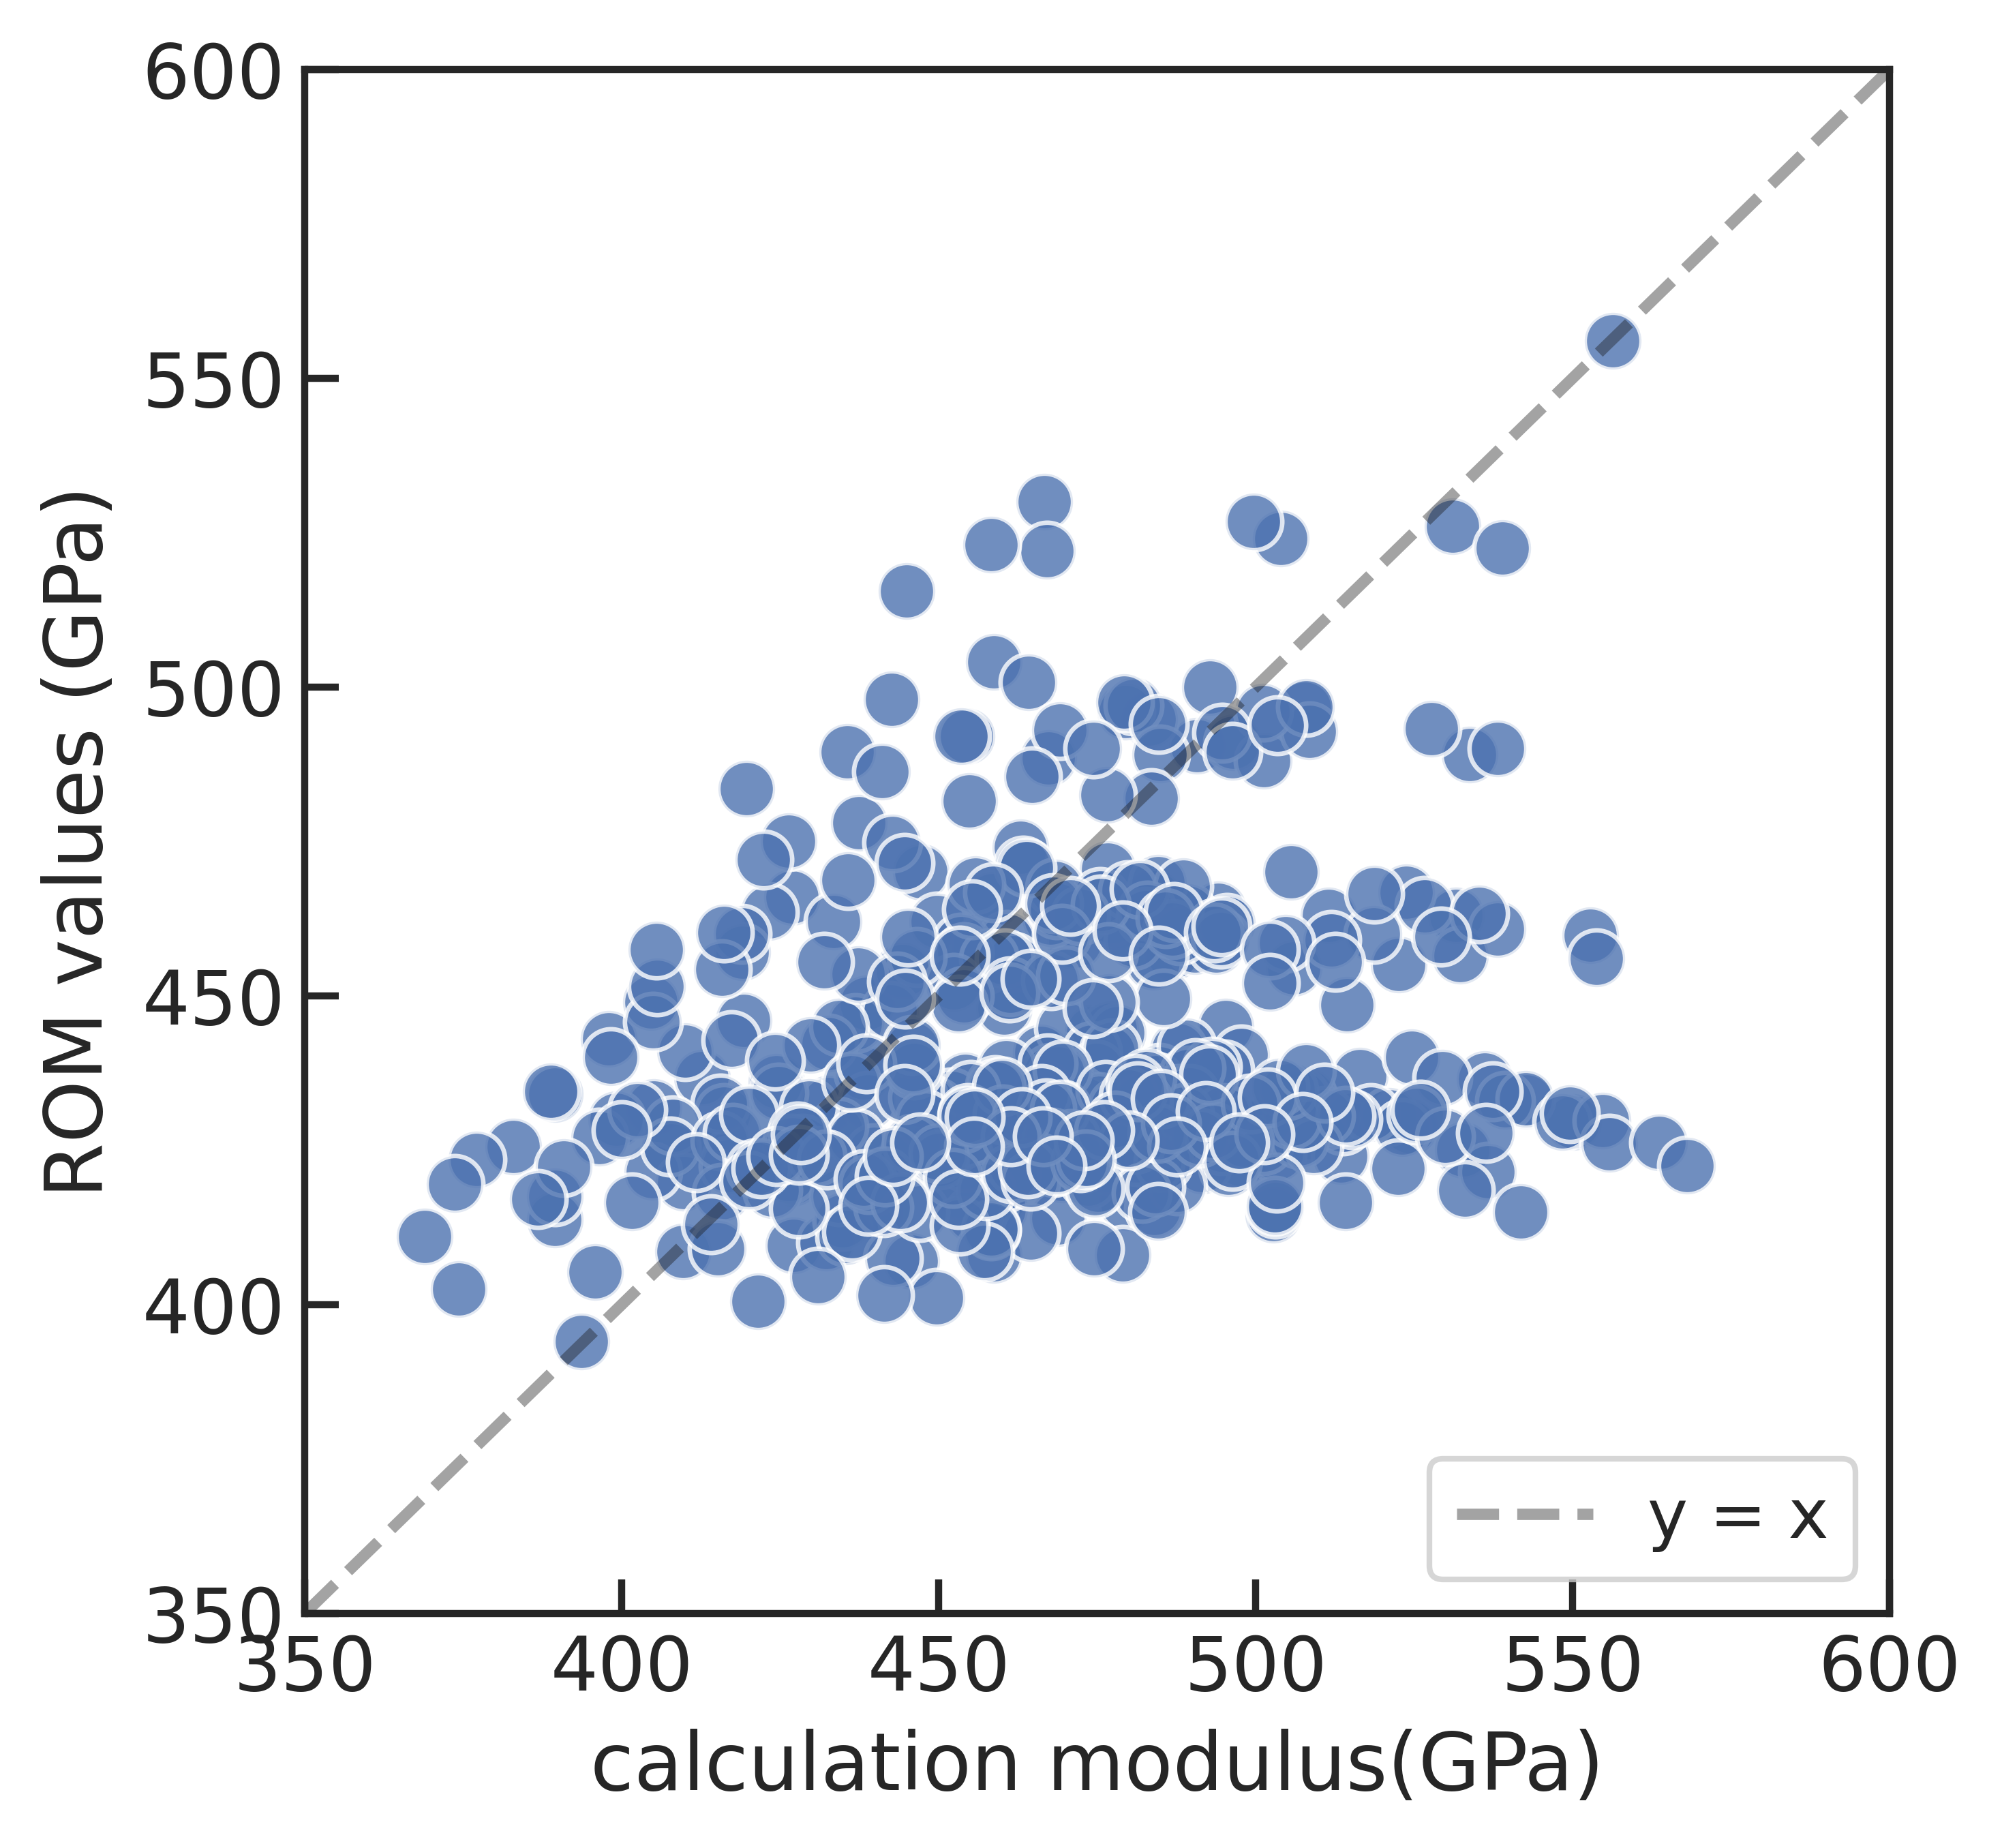

In [37]:
sns.set(style="ticks",font_scale=1.2)
plt.figure(figsize=(5,5),dpi=600)  ### 修改分辨率
axs = sns.scatterplot(data=df_modulus_no_Si, x= "young_modulus", y="mono_add",s=100,marker='o',alpha = 0.8, color = 'b')

axs.set_xlim(350,600)
axs.set_ylim(350,600)

formatXy = 'y = x'
axs.plot((0, 1), (0, 1), transform=axs.transAxes, linewidth=2, ls='--',c='k',alpha=0.4, label = formatXy)
axs.legend(loc = 'lower right', fontsize = 12)

plt.tick_params(left='on',bottom='on',direction='in')
plt.xlabel("calculation modulus(GPa)", fontdict={'size': 14})
plt.ylabel("ROM values (GPa)", fontdict={'size': 14})

plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/1.png', dpi = 600, bbox_inches = 'tight')   ### 保存图片

## Figure 1b

In [38]:
### 重新排序dataframe
df_modulus_no_Si = df_modulus_no_Si.reset_index(drop = True)

In [39]:
df_elem_modulus = pd.DataFrame()
young_modulus = []
shear_modulus = []
bulk_modulus = []
element = []
for i,s in enumerate(df_modulus_no_Si["structure"]): #495  
    if "Nb" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Nb")

for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "Ta" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Ta")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "Zr" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Zr")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "Hf" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Hf")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "Ti" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Ti")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "V" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("V")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "Mo" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Mo")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "W" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("W")
        
for i,s in enumerate(df_modulus_no_Si["structure"]):
    if "Cr" in df_modulus_no_Si["structure"][i].formula:
        young_modulus.append(df_modulus_no_Si["young_modulus"].loc[i])
        bulk_modulus.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        shear_modulus.append(df_modulus_no_Si["shear_modulus"].loc[i])
        element.append("Cr")
        

df_elem_modulus["young_modulus"] = young_modulus
df_elem_modulus["bulk_modulus"] = bulk_modulus
df_elem_modulus["shear_modulus"] = shear_modulus

df_elem_modulus['element'] = element

In [40]:
df_elem_modulus

young_modulus  bulk_modulus  shear_modulus element
0           424.355       277.584        170.395      Nb
1           460.284       266.288        189.900      Nb
2           467.500       286.168        190.393      Nb
3           478.206       279.104        196.883      Nb
4           497.751       287.570        205.424      Nb
...             ...           ...            ...     ...
1480        476.131       327.805        189.253      Cr
1481        473.201       345.135        186.081      Cr
1482        405.478       252.615        164.497      Cr
1483        428.202       258.681        174.903      Cr
1484        399.981       244.938        162.881      Cr

[1485 rows x 4 columns]

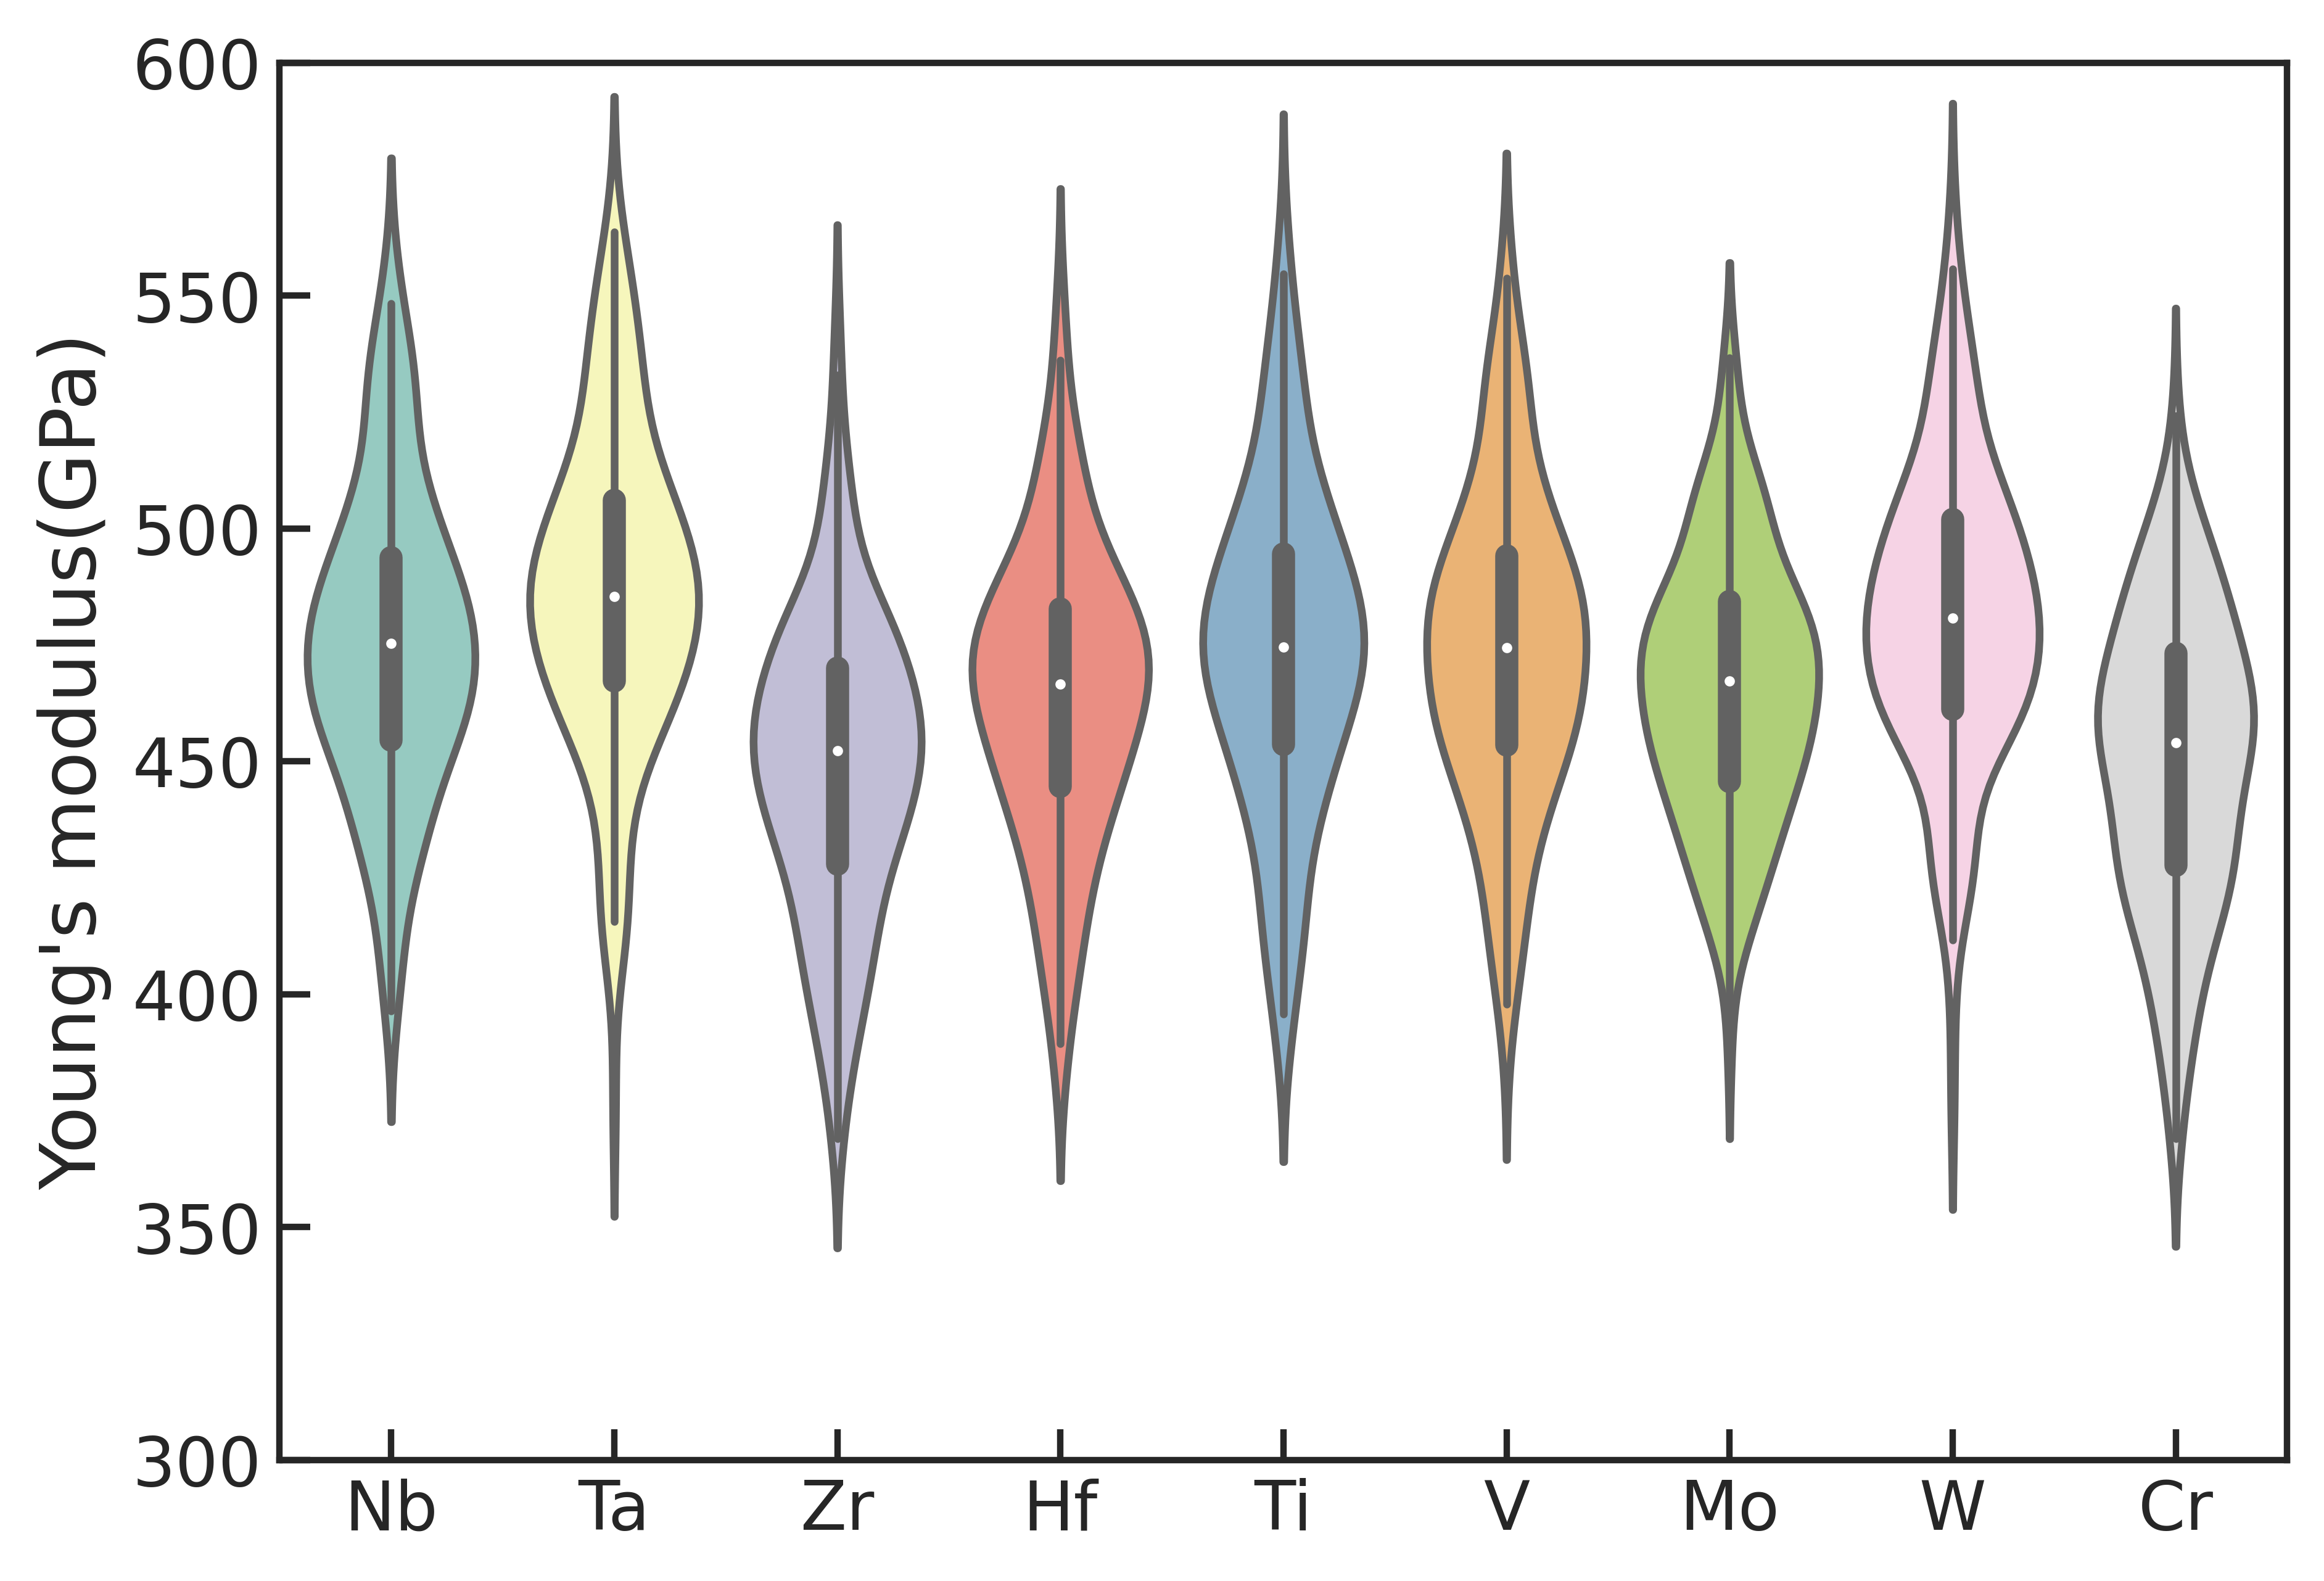

In [41]:
### 对比元素种类对弹性模量的影响
sns.set(style="ticks",font_scale=1.2)
plt.figure(figsize=(7,5),dpi=600)  ### 修改分辨率

axs = sns.violinplot(data=df_elem_modulus, x = "element",y="young_modulus",palette = "Set3")


axs.set_ylim(300,600)



plt.tick_params(left='on',bottom='on',direction='in')
plt.xlabel("")
plt.ylabel("Young's modulus(GPa)", fontdict={'size': 15})

plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/elem.png', dpi = 600, bbox_inches = 'tight')   ### 保存图片

Text(0, 0.5, 'Elastic properties(GPa)')

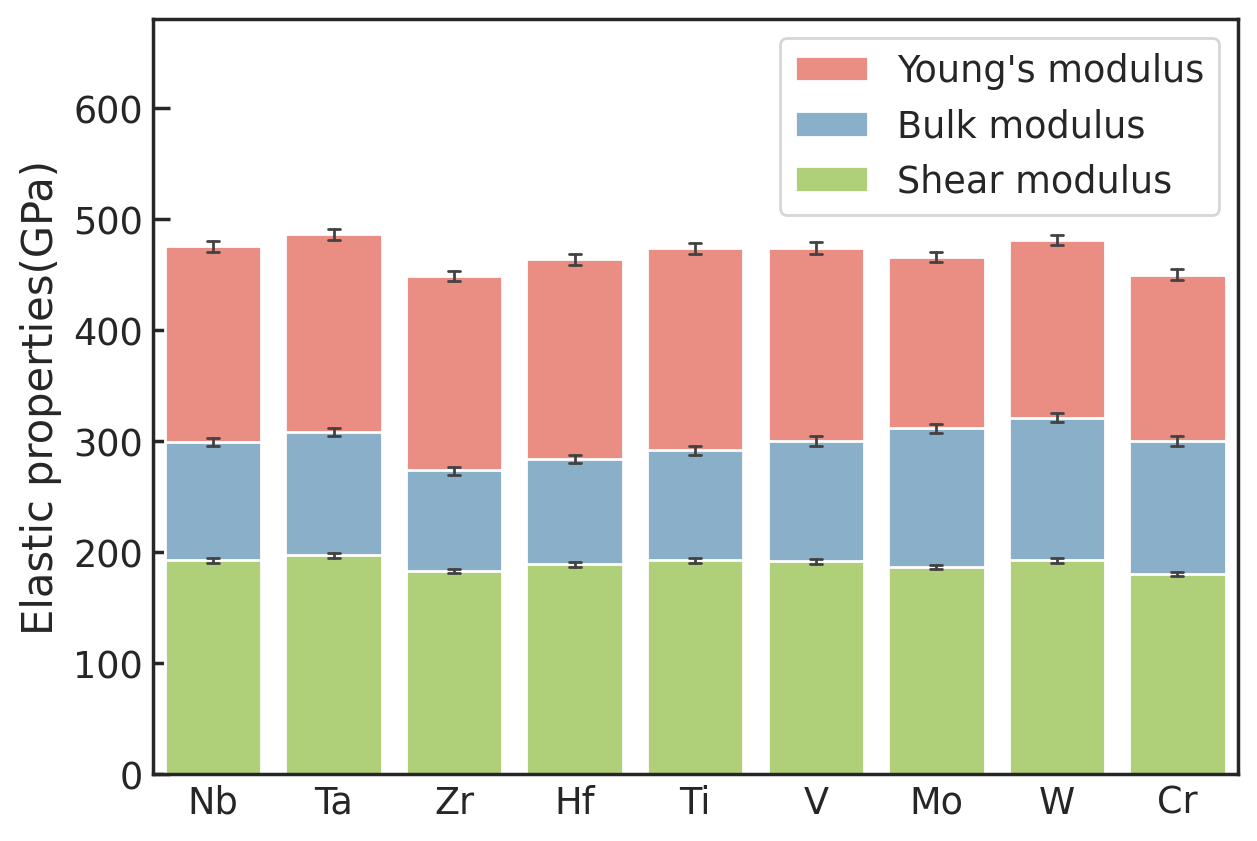

In [205]:
sns.set(style="ticks",font_scale=1.2)
plt.figure(figsize=(7,5),dpi=200)  ### 修改分辨率

axs = sns.barplot(data=df_elem_modulus, x = "element",y="",color = "#FB8072",label = "Young's modulus",capsize=.1,errwidth=1)
axs = sns.barplot(data=df_elem_modulus, x = "element",y="bulk_modulus",color = "#80B1D3",label = "Bulk modulus",capsize=.1,errwidth=1)
axs = sns.barplot(data=df_elem_modulus, x = "element",y="shear_modulus",color = "#B3DE69",label = "Shear modulus",capsize=.1,errwidth=1)


axs.set_ylim(0,680)
plt.legend()

plt.tick_params(left='on',bottom='on',direction='in')
plt.xlabel("",fontdict={'size': 15})
plt.ylabel("Elastic properties(GPa)", fontdict={'size': 15})

## Figure 2

In [42]:
###  元素数量对弹性模量的影响
#NbC= 436 TaC=422; ZrC=394; HfC=452; TiC=439; VC=556; MoC=420; WC=424; CrC=428;
Nb_young = []
Nb_shear = []
Nb_bulk = []
xlabel = []
df_Nb = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Nb1') == 1:
        Nb_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Nb_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Nb_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Nb2') == 1:
        Nb_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Nb_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Nb_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Nb3') == 1:  
        Nb_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Nb_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Nb_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Nb_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Nb_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Nb_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Nb['young'] = Nb_young  
df_Nb['shear'] = Nb_shear
df_Nb['bulk'] = Nb_bulk
df_Nb['num_Nb'] = xlabel
df_Nb.sort_values('num_Nb',inplace=True)

##### Ta
Ta_young = []
Ta_shear = []
Ta_bulk = []
xlabel = []
df_Ta = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Ta1') == 1:
        Ta_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ta_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ta_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Ta2') == 1:
        Ta_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ta_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ta_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Ta3') == 1:  
        Ta_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ta_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ta_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Ta_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ta_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ta_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Ta['young'] = Ta_young  
df_Ta['shear'] = Ta_shear
df_Ta['bulk'] = Ta_bulk     
df_Ta['num_Ta'] = xlabel
df_Ta.sort_values('num_Ta',inplace=True)

##### Zr
Zr_young = []
Zr_shear = []
Zr_bulk = []
xlabel = []
df_Zr = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Zr1') == 1:
        Zr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Zr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Zr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Zr2') == 1:
        Zr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Zr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Zr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Zr3') == 1:  
        Zr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Zr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Zr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Zr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Zr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Zr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Zr['young'] = Zr_young  
df_Zr['shear'] = Zr_shear
df_Zr['bulk'] = Zr_bulk       
df_Zr['num_Zr'] = xlabel
df_Zr.sort_values('num_Zr',inplace=True)

#### Hf
Hf_young = []
Hf_shear = []
Hf_bulk = []
xlabel = []
df_Hf = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Hf1') == 1:
        Hf_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Hf_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Hf_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Hf2') == 1:
        Hf_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Hf_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Hf_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Hf3') == 1:  
        Hf_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Hf_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Hf_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Hf_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Hf_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Hf_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Hf['young'] = Hf_young  
df_Hf['shear'] = Hf_shear
df_Hf['bulk'] = Hf_bulk       
df_Hf['num_Hf'] = xlabel
df_Hf.sort_values('num_Hf',inplace=True)

#### Ti
Ti_young = []
Ti_shear = []
Ti_bulk = []
xlabel = []
df_Ti = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Ti1') == 1:
        Ti_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ti_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ti_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Ti2') == 1:
        Ti_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ti_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ti_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Ti3') == 1:  
        Ti_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ti_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ti_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Ti_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Ti_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Ti_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Ti['young'] = Ti_young  
df_Ti['shear'] = Ti_shear
df_Ti['bulk'] = Ti_bulk       
df_Ti['num_Ti'] = xlabel
df_Ti.sort_values('num_Ti',inplace=True)

#### V
V_young = []
V_shear = []
V_bulk = []
xlabel = []
df_V = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('V1') == 1:
        V_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        V_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        V_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('V2') == 1:
        V_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        V_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        V_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('V3') == 1:  
        V_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        V_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        V_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        V_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        V_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        V_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_V['young'] = V_young  
df_V['shear'] = V_shear
df_V['bulk'] = V_bulk       
df_V['num_V'] = xlabel
df_V.sort_values('num_V',inplace=True)

#### Mo
Mo_young = []
Mo_shear = []
Mo_bulk = []
xlabel = []
df_Mo = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Mo1') == 1:
        Mo_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Mo_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Mo_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Mo2') == 1:
        Mo_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Mo_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Mo_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Mo3') == 1:  
        Mo_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Mo_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Mo_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Mo_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Mo_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Mo_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Mo['young'] = Mo_young  
df_Mo['shear'] = Mo_shear
df_Mo['bulk'] = Mo_bulk       
df_Mo['num_Mo'] = xlabel
df_Mo.sort_values('num_Mo',inplace=True)
        

#### W
W_young = []
W_shear = []
W_bulk = []
xlabel = []
df_W = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('W1') == 1:
        W_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        W_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        W_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('W2') == 1:
        W_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        W_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        W_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('W3') == 1:  
        W_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        W_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        W_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        W_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        W_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        W_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_W['young'] = W_young  
df_W['shear'] = W_shear
df_W['bulk'] = W_bulk       
df_W['num_W'] = xlabel
df_W.sort_values('num_W',inplace=True)

#### Cr
Cr_young = []
Cr_shear = []
Cr_bulk = []
xlabel = []
df_Cr = pd.DataFrame()

for i,s in enumerate(df_modulus_no_Si["structure"]):
    
    if s.formula.count('Cr1') == 1:
        Cr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Cr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Cr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('1')
    elif s.formula.count('Cr2') == 1:
        Cr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Cr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Cr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('2')
    elif s.formula.count('Cr3') == 1:  
        Cr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Cr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Cr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('3')
    else:
        Cr_young.append(df_modulus_no_Si["young_modulus"].loc[i])
        Cr_shear.append(df_modulus_no_Si["shear_modulus"].loc[i])
        Cr_bulk.append(df_modulus_no_Si["bulk_modulus"].loc[i])
        xlabel.append('0')
        
df_Cr['young'] = Cr_young  
df_Cr['shear'] = Cr_shear
df_Cr['bulk'] = Cr_bulk       
df_Cr['num_Cr'] = xlabel
df_Cr.sort_values('num_Cr',inplace=True)

In [43]:
df_W

young    shear     bulk num_W
0    389.372  152.694  288.436     0
300  444.942  181.397  271.075     0
298  395.742  163.783  225.980     0
295  453.527  178.838  325.790     0
293  404.939  166.694  236.490     0
..       ...      ...      ...   ...
120  518.177  207.207  345.982     3
309  514.151  206.690  334.434     3
236  396.426  150.634  358.800     3
275  377.028  141.820  368.003     3
191  444.590  170.808  373.166     3

[495 rows x 4 columns]

In [46]:
#NbC= 436 TaC=422; ZrC=394; HfC=452; TiC=439; VC=556; MoC=420; WC=424; CrC=428;
fig, axs = plt.subplots(3, 3, figsize=(18, 18),dpi=600)
sns.set(style="ticks",font_scale=1.3)

axs[0,0].set(xlabel='Nb atom',ylabel='calc modulus(GPa)')
axs[0,1].set(xlabel='Ta atom',ylabel='calc modulus(GPa)')
axs[0,2].set(xlabel='Zr atom',ylabel='calc modulus(GPa)')
axs[1,0].set(xlabel='Hf atom',ylabel='calc modulus(GPa)')
axs[1,1].set(xlabel='Ti atom',ylabel='calc modulus(GPa)')
axs[1,2].set(xlabel='V atom',ylabel='calc modulus(GPa)')
axs[2,0].set(xlabel='Mo atom',ylabel='calc modulus(GPa)')
axs[2,1].set(xlabel='W atom',ylabel='calc modulus(GPa)')
axs[2,2].set(xlabel='Cr atom',ylabel='calc modulus(GPa)')

sns.scatterplot(data=df_Nb, x= "num_Nb", y="young", s=100,marker='o',color="darkblue",ax=axs[0,0])
sns.scatterplot(data=df_Ta, x= "num_Ta", y="young", s=100,marker='o',color="green",ax=axs[0,1])
sns.scatterplot(data=df_Zr, x= "num_Zr", y="young", s=100,marker='o',color="crimson",ax=axs[0,2])
sns.scatterplot(data=df_Hf, x= "num_Hf", y="young", s=100,marker='o',color="saddlebrown",ax=axs[1,0])
sns.scatterplot(data=df_Ti, x= "num_Ti", y="young", s=100,marker='o',color="darkorange",ax=axs[1,1])
sns.scatterplot(data=df_V, x= "num_V", y="young", s=100,marker='o',color="gold",ax=axs[1,2])
sns.scatterplot(data=df_Mo, x= "num_Mo", y="young", s=100,marker='o',color="mediumslateblue",ax=axs[2,0])
sns.scatterplot(data=df_W, x= "num_W", y="young", s=100,marker='o',color="lightcoral",ax=axs[2,1])
sns.scatterplot(data=df_Cr, x= "num_Cr", y="young", s=100,marker='o',color="hotpink",ax=axs[2,2])

plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/elem_num.png', dpi = 600, bbox_inches = 'tight')

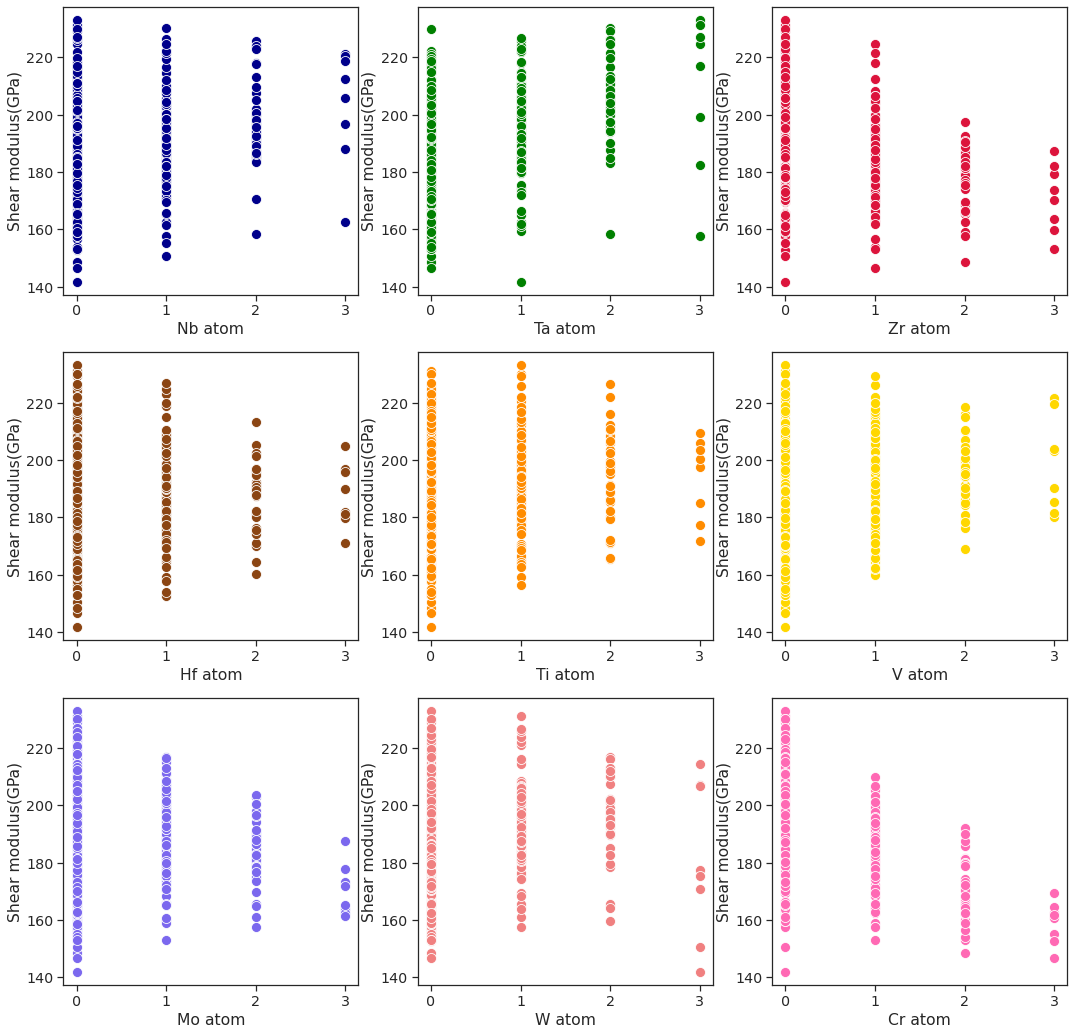

In [53]:
#NbC= 436 TaC=422; ZrC=394; HfC=452; TiC=439; VC=556; MoC=420; WC=424; CrC=428;
fig, axs = plt.subplots(3, 3, figsize=(18, 18))
sns.set(style="ticks",font_scale=1.3)

axs[0,0].set(xlabel='Nb atom',ylabel='Shear modulus(GPa)')
axs[0,1].set(xlabel='Ta atom',ylabel='Shear modulus(GPa)')
axs[0,2].set(xlabel='Zr atom',ylabel='Shear modulus(GPa)')
axs[1,0].set(xlabel='Hf atom',ylabel='Shear modulus(GPa)')
axs[1,1].set(xlabel='Ti atom',ylabel='Shear modulus(GPa)')
axs[1,2].set(xlabel='V atom',ylabel='Shear modulus(GPa)')
axs[2,0].set(xlabel='Mo atom',ylabel='Shear modulus(GPa)')
axs[2,1].set(xlabel='W atom',ylabel='Shear modulus(GPa)')
axs[2,2].set(xlabel='Cr atom',ylabel='Shear modulus(GPa)')

sns.scatterplot(data=df_Nb, x= "num_Nb", y="shear", s=100,marker='o',color="darkblue",ax=axs[0,0])
sns.scatterplot(data=df_Ta, x= "num_Ta", y="shear", s=100,marker='o',color="green",ax=axs[0,1])
sns.scatterplot(data=df_Zr, x= "num_Zr", y="shear", s=100,marker='o',color="crimson",ax=axs[0,2])
sns.scatterplot(data=df_Hf, x= "num_Hf", y="shear", s=100,marker='o',color="saddlebrown",ax=axs[1,0])
sns.scatterplot(data=df_Ti, x= "num_Ti", y="shear", s=100,marker='o',color="darkorange",ax=axs[1,1])
sns.scatterplot(data=df_V, x= "num_V", y="shear", s=100,marker='o',color="gold",ax=axs[1,2])
sns.scatterplot(data=df_Mo, x= "num_Mo", y="shear", s=100,marker='o',color="mediumslateblue",ax=axs[2,0])
sns.scatterplot(data=df_W, x= "num_W", y="shear", s=100,marker='o',color="lightcoral",ax=axs[2,1])
sns.scatterplot(data=df_Cr, x= "num_Cr", y="shear", s=100,marker='o',color="hotpink",ax=axs[2,2])

plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/elem_num_shear.png', dpi = 600, bbox_inches = 'tight')

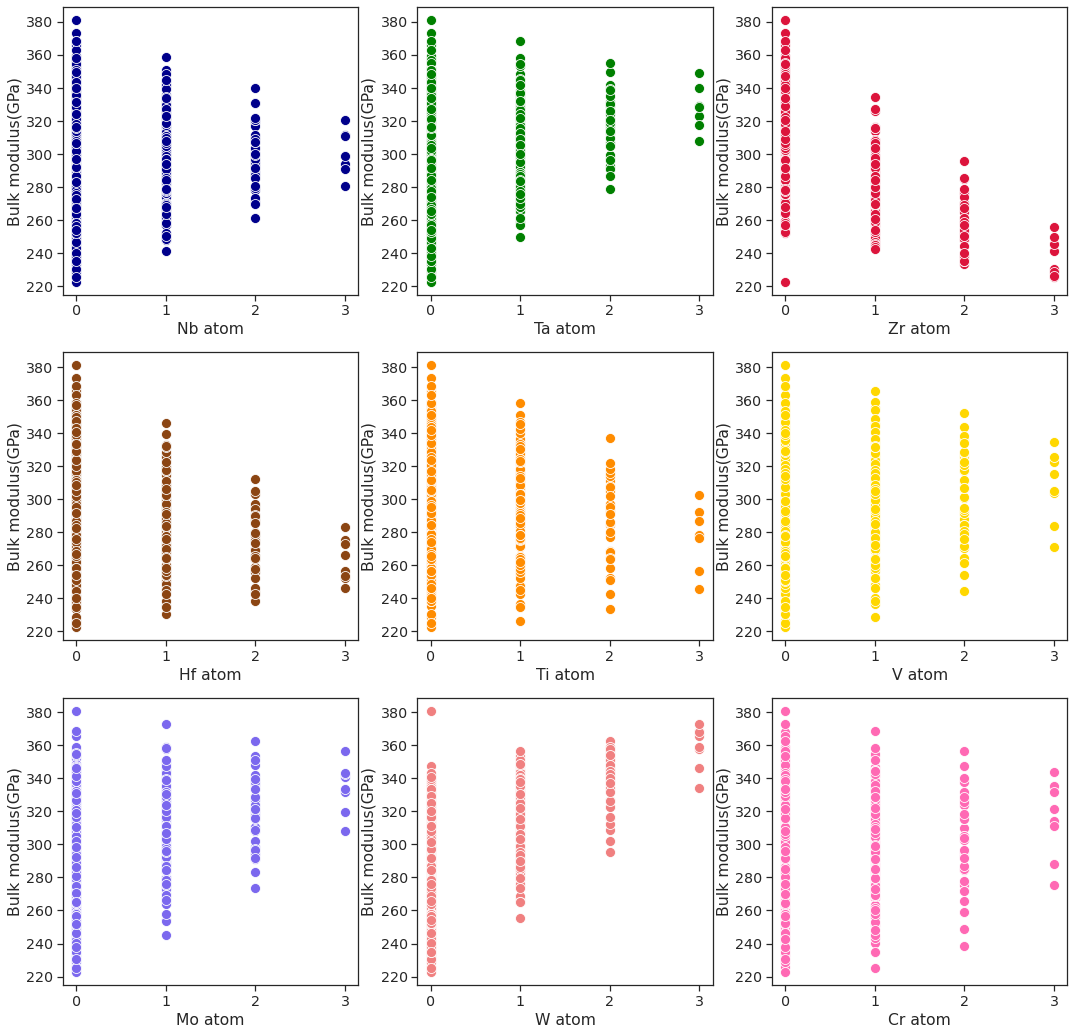

In [54]:
#NbC= 436 TaC=422; ZrC=394; HfC=452; TiC=439; VC=556; MoC=420; WC=424; CrC=428;
fig, axs = plt.subplots(3, 3, figsize=(18, 18))
sns.set(style="ticks",font_scale=1.3)

axs[0,0].set(xlabel='Nb atom',ylabel='Bulk modulus(GPa)')
axs[0,1].set(xlabel='Ta atom',ylabel='Bulk modulus(GPa)')
axs[0,2].set(xlabel='Zr atom',ylabel='Bulk modulus(GPa)')
axs[1,0].set(xlabel='Hf atom',ylabel='Bulk modulus(GPa)')
axs[1,1].set(xlabel='Ti atom',ylabel='Bulk modulus(GPa)')
axs[1,2].set(xlabel='V atom',ylabel='Bulk modulus(GPa)')
axs[2,0].set(xlabel='Mo atom',ylabel='Bulk modulus(GPa)')
axs[2,1].set(xlabel='W atom',ylabel='Bulk modulus(GPa)')
axs[2,2].set(xlabel='Cr atom',ylabel='Bulk modulus(GPa)')

sns.scatterplot(data=df_Nb, x= "num_Nb", y="bulk", s=100,marker='o',color="darkblue",ax=axs[0,0])
sns.scatterplot(data=df_Ta, x= "num_Ta", y="bulk", s=100,marker='o',color="green",ax=axs[0,1])
sns.scatterplot(data=df_Zr, x= "num_Zr", y="bulk", s=100,marker='o',color="crimson",ax=axs[0,2])
sns.scatterplot(data=df_Hf, x= "num_Hf", y="bulk", s=100,marker='o',color="saddlebrown",ax=axs[1,0])
sns.scatterplot(data=df_Ti, x= "num_Ti", y="bulk", s=100,marker='o',color="darkorange",ax=axs[1,1])
sns.scatterplot(data=df_V, x= "num_V", y="bulk", s=100,marker='o',color="gold",ax=axs[1,2])
sns.scatterplot(data=df_Mo, x= "num_Mo", y="bulk", s=100,marker='o',color="mediumslateblue",ax=axs[2,0])
sns.scatterplot(data=df_W, x= "num_W", y="bulk", s=100,marker='o',color="lightcoral",ax=axs[2,1])
sns.scatterplot(data=df_Cr, x= "num_Cr", y="bulk", s=100,marker='o',color="hotpink",ax=axs[2,2])

plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/elem_num_bulk.png', dpi = 600, bbox_inches = 'tight')

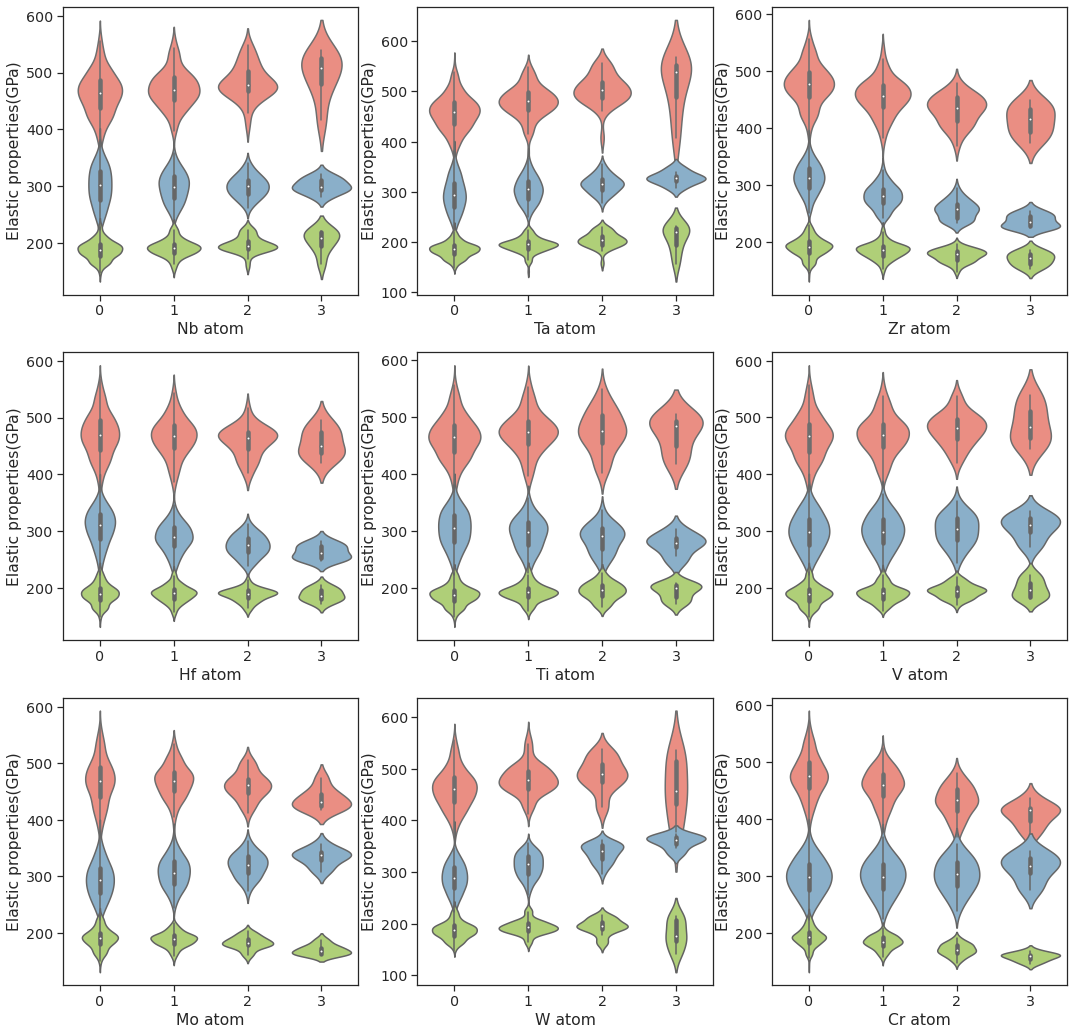

In [61]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18))
sns.set(style="ticks",font_scale=1.3)




sns.violinplot(data=df_Nb, x = "num_Nb",y="young",color = "#FB8072",ax=axs[0,0])
sns.violinplot(data=df_Nb, x = "num_Nb",y="bulk",color = "#80B1D3",ax=axs[0,0])
sns.violinplot(data=df_Nb, x = "num_Nb",y="shear",color = "#B3DE69",ax=axs[0,0])

sns.violinplot(data=df_Ta, x = "num_Ta",y="young",color = "#FB8072",ax=axs[0,1])
sns.violinplot(data=df_Ta, x = "num_Ta",y="bulk",color = "#80B1D3",ax=axs[0,1])
sns.violinplot(data=df_Ta, x = "num_Ta",y="shear",color = "#B3DE69",ax=axs[0,1])

sns.violinplot(data=df_Zr, x = "num_Zr",y="young",color = "#FB8072",ax=axs[0,2])
sns.violinplot(data=df_Zr, x = "num_Zr",y="bulk",color = "#80B1D3",ax=axs[0,2])
sns.violinplot(data=df_Zr, x = "num_Zr",y="shear",color = "#B3DE69",ax=axs[0,2])

sns.violinplot(data=df_Hf, x = "num_Hf",y="young",color = "#FB8072",ax=axs[1,0])
sns.violinplot(data=df_Hf, x = "num_Hf",y="bulk",color = "#80B1D3",ax=axs[1,0])
sns.violinplot(data=df_Hf, x = "num_Hf",y="shear",color = "#B3DE69",ax=axs[1,0])

sns.violinplot(data=df_Ti, x = "num_Ti",y="young",color = "#FB8072",ax=axs[1,1])
sns.violinplot(data=df_Ti, x = "num_Ti",y="bulk",color = "#80B1D3",ax=axs[1,1])
sns.violinplot(data=df_Ti, x = "num_Ti",y="shear",color = "#B3DE69",ax=axs[1,1])

sns.violinplot(data=df_V, x = "num_V",y="young",color = "#FB8072",ax=axs[1,2])
sns.violinplot(data=df_V, x = "num_V",y="bulk",color = "#80B1D3",ax=axs[1,2])
sns.violinplot(data=df_V, x = "num_V",y="shear",color = "#B3DE69",ax=axs[1,2])

sns.violinplot(data=df_Mo, x = "num_Mo",y="young",color = "#FB8072",ax=axs[2,0])
sns.violinplot(data=df_Mo, x = "num_Mo",y="bulk",color = "#80B1D3",ax=axs[2,0])
sns.violinplot(data=df_Mo, x = "num_Mo",y="shear",color = "#B3DE69",ax=axs[2,0])

sns.violinplot(data=df_W, x = "num_W",y="young",color = "#FB8072",ax=axs[2,1])
sns.violinplot(data=df_W, x = "num_W",y="bulk",color = "#80B1D3",ax=axs[2,1])
sns.violinplot(data=df_W, x = "num_W",y="shear",color = "#B3DE69",ax=axs[2,1])

sns.violinplot(data=df_Cr, x = "num_Cr",y="young",color = "#FB8072",ax=axs[2,2])
sns.violinplot(data=df_Cr, x = "num_Cr",y="bulk",color = "#80B1D3",ax=axs[2,2])
sns.violinplot(data=df_Cr, x = "num_Cr",y="shear",color = "#B3DE69",ax=axs[2,2])

axs[0,0].set(xlabel='Nb atom',ylabel='Elastic properties(GPa)')
axs[0,1].set(xlabel='Ta atom',ylabel='Elastic properties(GPa)')
axs[0,2].set(xlabel='Zr atom',ylabel='Elastic properties(GPa)')
axs[1,0].set(xlabel='Hf atom',ylabel='Elastic properties(GPa)')
axs[1,1].set(xlabel='Ti atom',ylabel='Elastic properties(GPa)')
axs[1,2].set(xlabel='V atom',ylabel='Elastic properties(GPa)')
axs[2,0].set(xlabel='Mo atom',ylabel='Elastic properties(GPa)')
axs[2,1].set(xlabel='W atom',ylabel='Elastic properties(GPa)')
axs[2,2].set(xlabel='Cr atom',ylabel='Elastic properties(GPa)')


plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/elastic_modulus_elem.png', dpi = 600, bbox_inches = 'tight')

In [20]:
# 读取第一个文件的特定列
df1 = pd.read_csv('/home/zhaoxi/Data/hardness_pred_566370.csv', usecols=['formula','pred'])

# 读取第二个文件的特定列
df2 = pd.read_csv('/home/zhaoxi/Data/young_pred_566370.csv', usecols=['pred'])

# 将两个DataFrame合并为一个新的DataFrame
# 如果你想在列方向上合并（即将第二个DataFrame的列放在第一个的旁边），使用axis=1
combined_df_566370 = pd.concat([df1, df2], axis=1)


In [23]:
combined_df_566370

hardness          formula       young
0       25.909161  Ta4Zr15Hf5V8C32  452.530731
1       26.158066   Ta8Zr21Hf2VC32  452.032196
2       26.836712  Ta15Zr6Hf2V9C32  496.514618
3       26.791525   TaZr4Hf21V6C32  469.710602
4       26.637226   TaZr17Hf5V9C32  452.437805
...           ...              ...         ...
566365  19.271965  Ti12Mo14W5CrC32  487.194763
566366  19.822853  Ti7Mo11W7Cr7C32  477.631897
566367  19.161430  Ti9Mo4W9Cr10C32  484.453522
566368  16.974216  Ti7Mo5W18Cr2C32  484.454346
566369  22.326466  Ti16Mo4W8Cr4C32  495.879303

[566370 rows x 3 columns]

In [22]:
combined_df_566370.columns = ["hardness","formula","young"]

In [25]:
combined_df_566370['H/E'] = np.where(combined_df_566370['young'] != 0, combined_df_566370['hardness'] / combined_df_566370['young'], np.nan)


In [26]:
combined_df_566370

hardness          formula       young       H/E
0       25.909161  Ta4Zr15Hf5V8C32  452.530731  0.057254
1       26.158066   Ta8Zr21Hf2VC32  452.032196  0.057868
2       26.836712  Ta15Zr6Hf2V9C32  496.514618  0.054050
3       26.791525   TaZr4Hf21V6C32  469.710602  0.057038
4       26.637226   TaZr17Hf5V9C32  452.437805  0.058875
...           ...              ...         ...       ...
566365  19.271965  Ti12Mo14W5CrC32  487.194763  0.039557
566366  19.822853  Ti7Mo11W7Cr7C32  477.631897  0.041502
566367  19.161430  Ti9Mo4W9Cr10C32  484.453522  0.039553
566368  16.974216  Ti7Mo5W18Cr2C32  484.454346  0.035038
566369  22.326466  Ti16Mo4W8Cr4C32  495.879303  0.045024

[566370 rows x 4 columns]

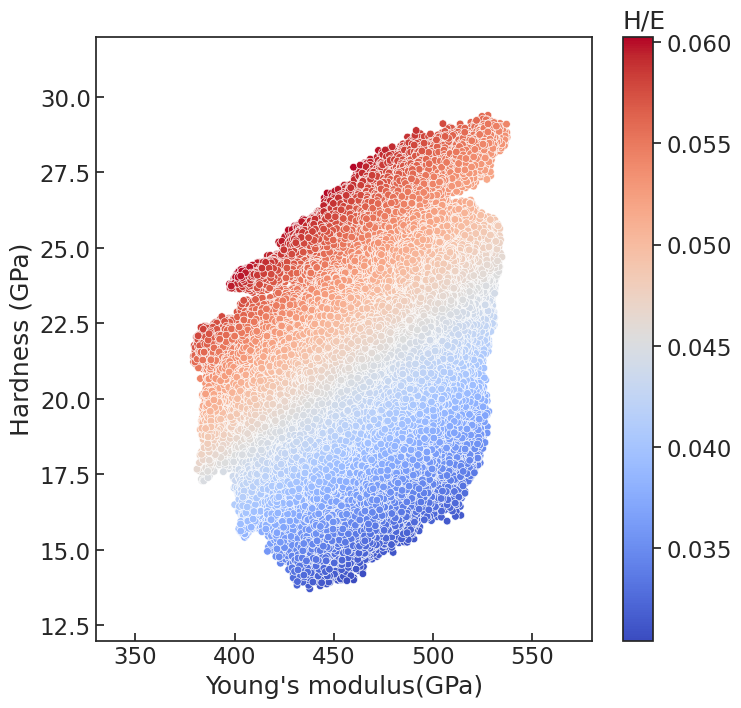

In [56]:


# 设置样式和字体大小
sns.set(style="ticks", font_scale=1.5)

# 设置画布大小和分辨率
plt.figure(figsize=(8, 8), dpi=100)

# 绘制散点图，并赋值给axs
axs = sns.scatterplot(data=combined_df_566370, x="young", y="hardness", hue='H/E', palette='coolwarm', s=30,marker='o', legend=False)

# 设置x轴和y轴的限制
axs.set_xlim(330, 580)
axs.set_ylim(12, 32)

# 添加颜色条
norm = plt.Normalize(combined_df_566370['H/E'].min(), combined_df_566370['H/E'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, aspect=20)
cbar.ax.set_title('H/E', loc='left')  # 设置colorbar的标题，位于顶部

# 设置刻度参数
plt.tick_params(left='on', bottom='on', direction='in')

# 设置轴标签和字体大小
plt.xlabel("Young's modulus(GPa)", fontdict={'size': 18})
plt.ylabel("Hardness (GPa)", fontdict={'size': 18})

# 保存图表

plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/566370.png', dpi = 600, bbox_inches = 'tight')   ### 保存图片

Text(0, 0.5, 'Hardness (GPa)')

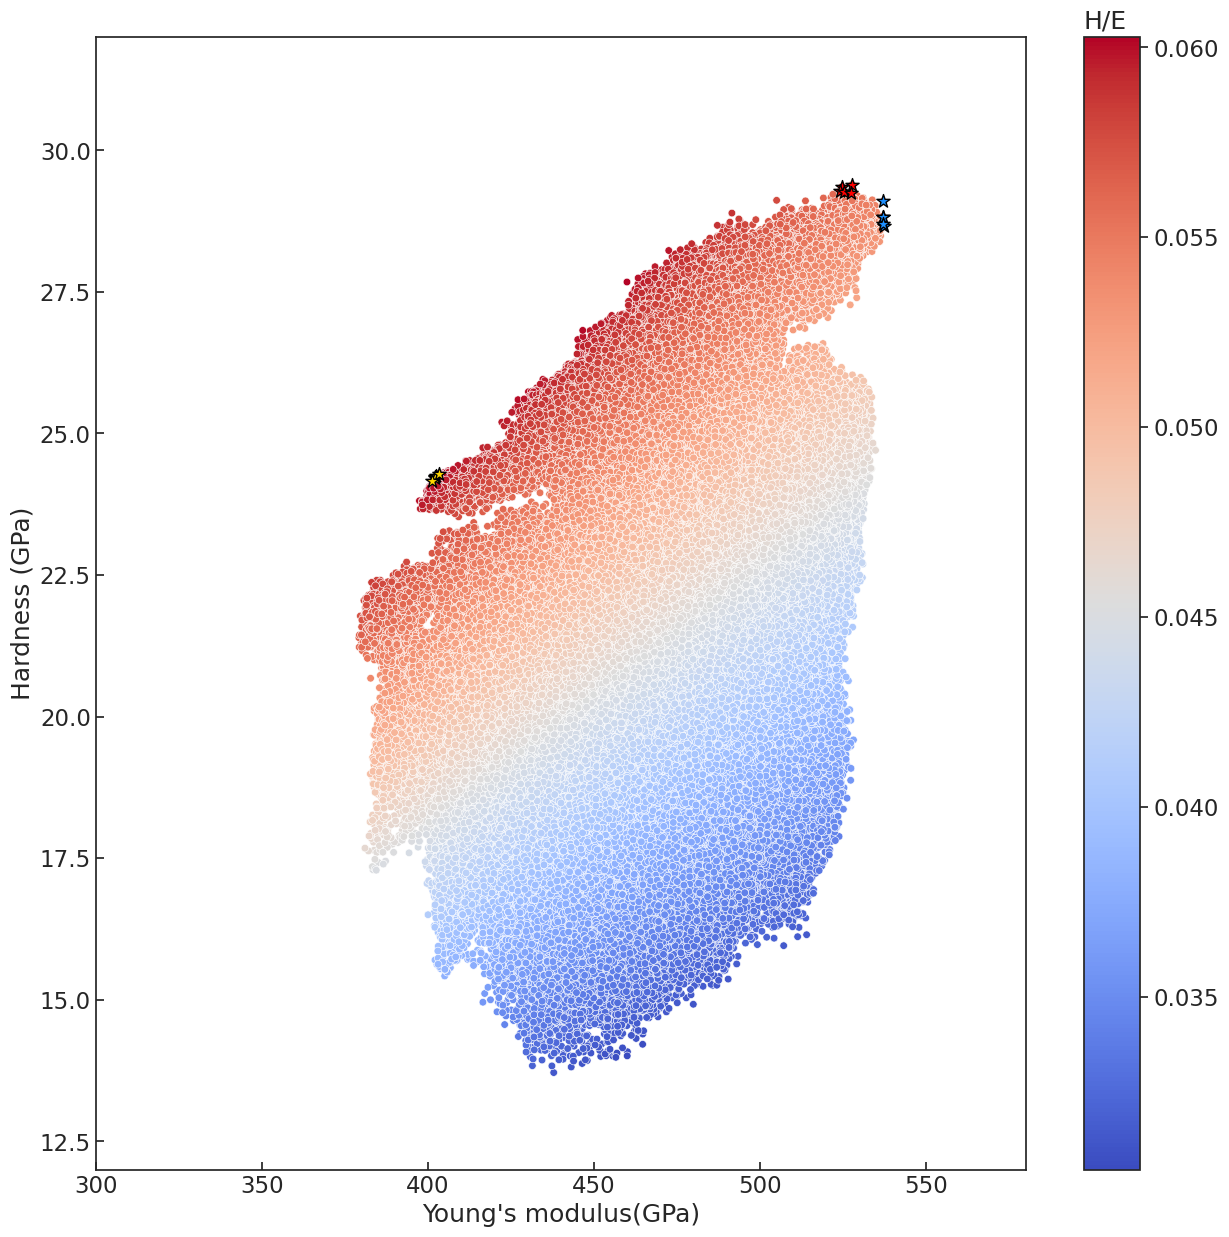

In [31]:


# 设置样式和字体大小
sns.set(style="ticks", font_scale=1.5)

# 设置画布大小和分辨率
plt.figure(figsize=(15, 15), dpi=100)

# 绘制原始散点图，并赋值给axs
axs = sns.scatterplot(data=combined_df_566370, x="young", y="hardness", hue='H/E', palette='coolwarm', s=30, marker='o', legend=False)

# 找到E最大的5个点
top_5_HE = combined_df_566370.nlargest(5, 'H/E')

# 找到H/E最大的10个点
top_5_E = combined_df_566370.nlargest(5, 'young')

# 找到H/E最大的10个点
top_5_H = combined_df_566370.nlargest(5, 'hardness')


# 在散点图上用星号标记这些点
plt.scatter(top_5_HE['young'], top_5_HE['hardness'], color='gold', s=100, marker='*', edgecolor='black', zorder=5)
plt.scatter(top_5_E['young'], top_5_E['hardness'], color='dodgerblue', s=100, marker='*', edgecolor='black', zorder=5)
plt.scatter(top_5_H['young'], top_5_H['hardness'], color='red', s=100, marker='*', edgecolor='black', zorder=5)

# 设置x轴和y轴的限制
axs.set_xlim(300, 580)
axs.set_ylim(12, 32)

# 添加颜色条
norm = plt.Normalize(combined_df_566370['H/E'].min(), combined_df_566370['H/E'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, aspect=20)
cbar.ax.set_title('H/E', loc='left')  # 设置colorbar的标题，位于顶部



# 设置刻度参数
plt.tick_params(left='on', bottom='on', direction='in')

# 设置轴标签和字体大小
plt.xlabel("Young's modulus(GPa)", fontdict={'size': 18})
plt.ylabel("Hardness (GPa)", fontdict={'size': 18})

# 保存图表
#plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/566370.png', dpi=600, bbox_inches='tight')


In [27]:
top_5_HE1 = combined_df_566370.nlargest(5, 'H/E')

In [29]:
top_5_HE1

hardness          formula       young       H/E
257241  24.232367   Zr24Hf4VTi3C32  402.075684  0.060268
259591  24.251808   Zr24HfV4Ti3C32  402.602264  0.060238
259994  24.218325  Zr18Hf2V11TiC32  402.080750  0.060232
260449  24.290836  Zr16Hf4V11TiC32  403.333923  0.060225
258191  24.157145   Zr24Hf3VTi4C32  401.286133  0.060199

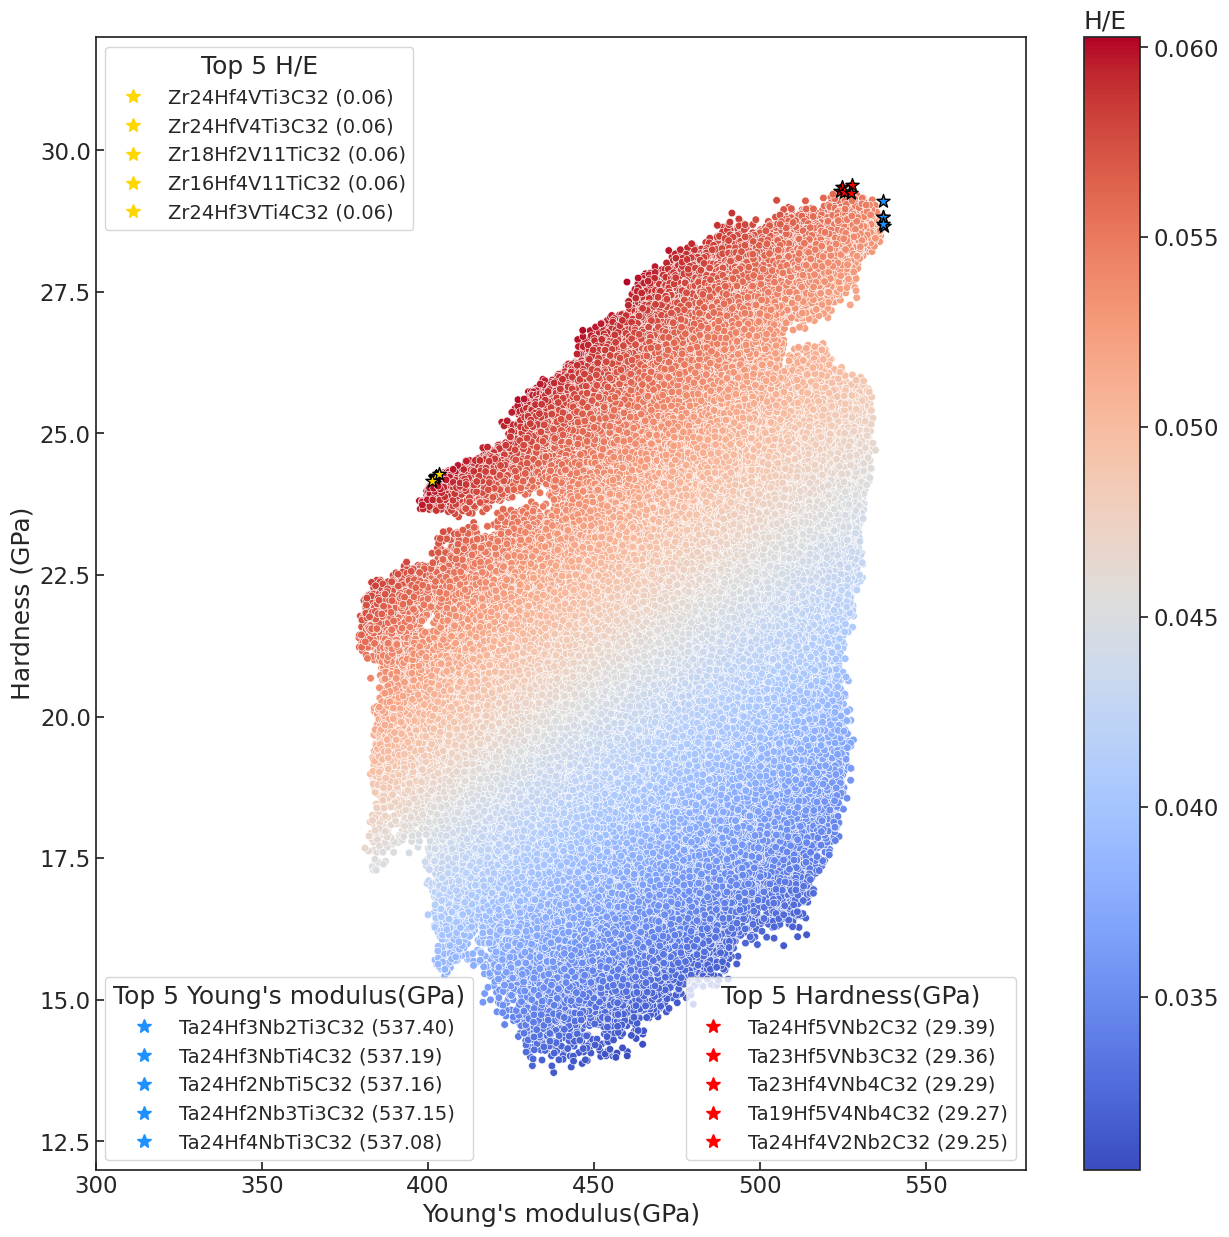

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

# 假设 combined_df_566370 是您的 DataFrame

# 设置样式和字体大小
sns.set(style="ticks", font_scale=1.5)

# 设置画布大小和分辨率
plt.figure(figsize=(15, 15), dpi=100)

# 绘制原始散点图，并赋值给 ax
ax = sns.scatterplot(data=combined_df_566370, x="young", y="hardness", hue='H/E', palette='coolwarm', s=30, marker='o', legend=False)

# 找到 H/E, young, hardness 最大的5个点
top_5_HE = combined_df_566370.nlargest(5, 'H/E')
top_5_E = combined_df_566370.nlargest(5, 'young')
top_5_H = combined_df_566370.nlargest(5, 'hardness')

# 在散点图上用不同颜色的星号标记这些点
plt.scatter(top_5_HE['young'], top_5_HE['hardness'], color='gold', s=100, marker='*', edgecolor='black', zorder=5)
plt.scatter(top_5_E['young'], top_5_E['hardness'], color='dodgerblue', s=100, marker='*', edgecolor='black', zorder=5)
plt.scatter(top_5_H['young'], top_5_H['hardness'], color='red', s=100, marker='*', edgecolor='black', zorder=5)

# 创建自定义图例项
legend_1 = [mlines.Line2D([0], [0], color='gold', marker='*', linestyle='None', markersize=10, label=f'{row["formula"]} ({row["H/E"]:.2f})') for _, row in top_5_HE.iterrows()]
legend_2 = [mlines.Line2D([0], [0], color='dodgerblue', marker='*', linestyle='None', markersize=10, label=f'{row["formula"]} ({row["young"]:.2f})') for _, row in top_5_E.iterrows()]
legend_3 = [mlines.Line2D([0], [0], color='red', marker='*', linestyle='None', markersize=10, label=f'{row["formula"]} ({row["hardness"]:.2f})') for _, row in top_5_H.iterrows()]

# 添加自定义图例
legend1 = ax.legend(handles=legend_1, title="Top 5 H/E", loc='upper left',fontsize = 14)
legend2 = ax.legend(handles=legend_2, title="Top 5 Young's modulus(GPa)", loc='lower left',fontsize = 14)
legend3 = ax.legend(handles=legend_3, title="Top 5 Hardness(GPa)", loc='lower right',fontsize = 14)

# 将先前的图例添加回图表中
ax.add_artist(legend1)
ax.add_artist(legend2)

# 设置x轴和y轴的限制
ax.set_xlim(300, 580)
ax.set_ylim(12, 32)

# 添加颜色条
norm = plt.Normalize(combined_df_566370['H/E'].min(), combined_df_566370['H/E'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, aspect=20)
cbar.ax.set_title('H/E', loc='left')

# 设置刻度参数和轴标签
plt.tick_params(left='on', bottom='on', direction='in')
plt.xlabel("Young's modulus(GPa)", fontdict={'size': 18})
plt.ylabel("Hardness (GPa)", fontdict={'size': 18})

# 保存图表
#plt.savefig('566370.png', dpi=600, bbox_inches='tight')


# 保存图表
plt.savefig('/mnt/e/ZHAO/Data/ELASTIC_HEC/Figure/566370.png', dpi=600, bbox_inches='tight')


## DATA PROCESS

In [65]:
df_modulus_no_Si

formula                                          structure  \
0            Hf1 Cr3 C4  [[0.        2.1250038 0.       ] C, [2.1250038...   
1            Cr3 Mo1 C4  [[0.         2.08341687 0.        ] C, [2.0834...   
2        Hf1 Cr2 Mo1 C4  [[0.        2.1643608 0.       ] C, [2.1555275...   
3        Hf1 Nb1 Cr2 C4  [[0.         2.18573619 0.        ] C, [2.1667...   
4            Ta3 Cr1 C4  [[0.         2.20279724 0.        ] C, [2.2027...   
..                  ...                                                ...   
490  Hf1 Zr1 Nb1 Cr1 C4  [[0.         2.25773673 0.        ] C, [2.2408...   
491  Hf1 Zr1 Ti1 Mo1 C4  [[0.         2.26051069 0.        ] C, [2.2507...   
492   Hf1 Zr1 Ti1 W1 C4  [[0.        2.2579031 0.       ] C, [2.2486180...   
493  Hf1 Zr1 Ti1 Cr1 C4  [[0.         2.24314281 0.        ] C, [2.2209...   
494   Hf1 Zr1 Mo1 W1 C4  [[0.         2.26225962 0.        ] C, [2.2394...   

     young_modulus  bulk_modulus  shear_modulus  hardness  mono_add  
0          389.372       288.436        152.694    14.870    434.00  
1          415.446       335.457        160.578    13.364    426.00  
2          405.053       296.660        159.164    15.595    432.00  
3          424.355       277.584        170.395    19.639    436.00  
4          497.590       328.912        199.377    21.448    423.50  
..             ...           ...            ...       ...       ...  
490        428.202       258.681        174.903    22.728    427.50  
491        447.043       264.227        183.513    24.300    426.25  
492        466.460       275.254        191.556    25.057    427.25  
493        399.981       244.938        162.881    21.208    428.25  
494        468.513       292.300        190.011    22.790    422.50  

[495 rows x 7 columns]

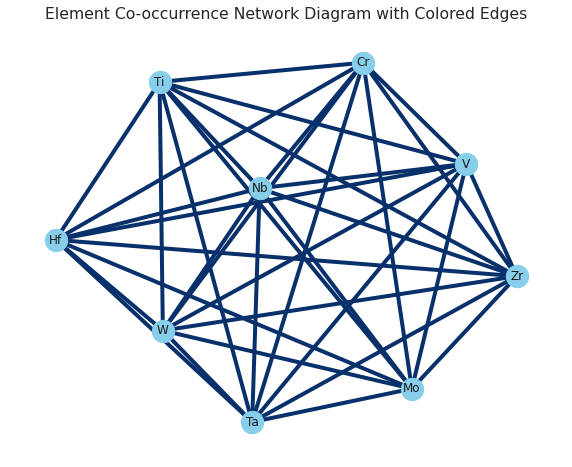

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import re
from itertools import combinations
from collections import defaultdict


# Define a function to parse the chemical formula and extract elements
def parse_formula(formula):
    # Use regex to find elements - capital letter followed by optional lowercase letters and numbers
    elements = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    # Return a list of elements without the stoichiometric numbers and excluding Carbon (C)
    return [el for el, num in elements if el != 'C']

# Apply the function to the 'formula' column
df_modulus_no_Si['elements'] = df_modulus_no_Si['formula'].apply(parse_formula)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes and edges to the graph
for index, row in df_modulus_no_Si.iterrows():
    # Create a node for each element if it doesn't already exist
    for element in row['elements']:
        if not G.has_node(element):
            G.add_node(element)

    # Create edges between all pairs of elements in the formula
    for element_pair in combinations(row['elements'], 2):
        # If the edge already exists, increment the weight
        if G.has_edge(*element_pair):
            G[element_pair[0]][element_pair[1]]['weight'] += 1
        else:
            # Otherwise, add a new edge with weight 1
            G.add_edge(element_pair[0], element_pair[1], weight=1)

# Generate positions for each node using a layout
pos = nx.spring_layout(G)

# Normalize weights and convert them to a list of colors for edge coloring
max_weight = max([G[u][v]['weight'] for u, v in G.edges()])
colors = [plt.cm.Blues(G[u][v]['weight']/max_weight) for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)  # Set a fixed width for better visibility
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title('Element Co-occurrence Network Diagram with Colored Edges')
plt.axis('off')
plt.show()


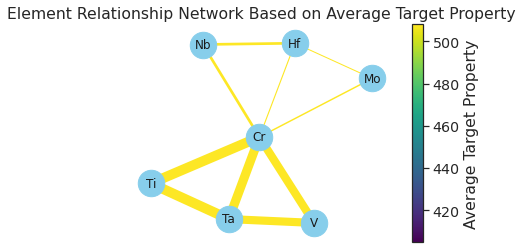

In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import re
from itertools import combinations

# Provided dataframe
df = pd.DataFrame({
    'formula': ['Hf1 Cr3 C4', 'Cr3 Mo1 C4', 'Hf1 Cr2 Mo1 C4', 'Hf1 Nb1 Cr2 C4', 'Ta3 Cr1 C4', 'Ta2 Ti1 Cr1 C4', 'Ta2 V1 Cr1 C4'],
    'target': [389.372, 415.446, 405.053, 424.355, 497.59, 508.107, 486.849]
})

# Define a function to parse the chemical formula and extract elements
def parse_formula(formula):
    elements = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    return [el for el, num in elements if el != 'C']

# Apply the function to the 'formula' column
df['elements'] = df['formula'].apply(parse_formula)

# Create a NetworkX graph
G = nx.Graph()

# Initialize a dictionary to store total target value and count for each pair of elements
pair_target_totals = defaultdict(lambda: {'total': 0, 'count': 0})

# Calculate the total target value for each pair of elements and the number of occurrences
for index, row in df.iterrows():
    for element_pair in combinations(row['elements'], 2):
        sorted_pair = tuple(sorted(element_pair))  # Sort the pair to avoid duplicates
        pair_target_totals[sorted_pair]['total'] += row['target']
        pair_target_totals[sorted_pair]['count'] += 1

# Add nodes and edges with the average target value as weight
for element_pair, data in pair_target_totals.items():
    average_target = data['total'] / data['count']
    G.add_edge(element_pair[0], element_pair[1], weight=average_target)

# Generate positions for each node using a layout
pos = nx.spring_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

# Draw the edges with a colormap reflecting the average target property
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
# Normalize weights for line width (mapping to range 1-10)
normalized_weights = [((weight - min(weights)) / (max(weights) - min(weights)) * 9 + 1) for weight in weights]
edge_colors = [plt.cm.viridis(weight) for weight in normalized_weights]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=normalized_weights)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=12)

# Add a colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm.set_array([])
plt.colorbar(sm, label='Average Target Property')

# Show the graph
plt.title('Element Relationship Network Based on Average Target Property')
plt.axis('off')
plt.show()


In [70]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Assuming df is the dataframe with the chemical formulas and target property
# And the parse_formula function is already defined

# Step 1: Discretize the target property into categories (let's assume three categories for simplicity)
df['target_category'] = pd.qcut(df['target'], q=3, labels=['Low', 'Medium', 'High'])

# Step 2: Transform the data for ARM
# Create a list of lists of the elements in each compound, including the target category
transactions = df.apply(lambda row: row['elements'] + [row['target_category']], axis=1).tolist()

# Perform one-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# Step 3: Use the apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_onehot, min_support=0.01, use_colnames=True)

# Step 4: Mine the association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Display the rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


antecedents       consequents   support  confidence      lift
0          (Cr)              (Hf)  0.428571    0.428571  1.000000
1          (Hf)              (Cr)  0.428571    1.000000  1.000000
2        (High)              (Cr)  0.285714    1.000000  1.000000
3          (Cr)            (High)  0.285714    0.285714  1.000000
4         (Low)              (Cr)  0.428571    1.000000  1.000000
..          ...               ...       ...         ...       ...
189    (Cr, Ta)       (Medium, V)  0.142857    0.333333  2.333333
190    (Medium)       (V, Cr, Ta)  0.142857    0.500000  3.500000
191         (V)  (Medium, Cr, Ta)  0.142857    1.000000  7.000000
192        (Cr)   (Medium, V, Ta)  0.142857    0.142857  1.000000
193        (Ta)   (Medium, V, Cr)  0.142857    0.333333  2.333333

[194 rows x 5 columns]

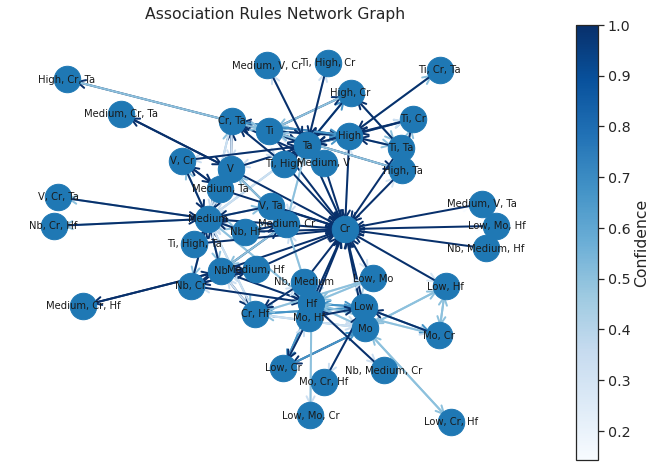

In [72]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the association rules
for _, rule in rules.iterrows():
    # Since antecedents and consequents are 'frozenset' types, we need to process them to be displayed as strings
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    
    # Add nodes
    G.add_node(antecedents)
    G.add_node(consequents)
    
    # Add a directed edge from antecedent to consequent
    G.add_edge(antecedents, consequents, weight=rule['confidence'])

# Draw the graph
plt.figure(figsize=(12, 8))

# Positions for all nodes
pos = nx.spring_layout(G)

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Edges
edges = G.edges()
confidence = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=20, edge_color=confidence, edge_cmap=plt.cm.Blues, width=2)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Add a color bar corresponding to the confidence values of the edges
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(confidence), vmax=max(confidence)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Confidence')

plt.title('Association Rules Network Graph')
plt.axis('off')
plt.show()


In [64]:
df_no_Si = data_process(df_modulus_no_Si)

StrToComposition:   0%|          | 0/495 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/495 [00:00<?, ?it/s]

CompositionToOxidComposition:   0%|          | 0/495 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/495 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/495 [00:00<?, ?it/s]

In [74]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming `associations` is a DataFrame with columns ['element1', 'element2', 'association_strength']
# where 'association_strength' is a numerical value representing the strength of the association.

# Create the graph
G = nx.Graph()

# Add nodes and edges from the association data
for idx, row in associations.iterrows():
    element1 = row['element1']
    element2 = row['element2']
    strength = row['association_strength']

    # Add nodes
    G.add_node(element1)
    G.add_node(element2)
    
    # Add an edge with the association strength as weight
    G.add_edge(element1, element2, weight=strength)

# Generate positions for each node using a layout
pos = nx.spring_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Draw the edges with a colormap
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
edge_colors = [weight for weight in weights]  # This could be adjusted to map to your color scale
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color=edge_colors)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Display the graph
plt.show()


NameError: name 'associations' is not defined

In [25]:
df_no_Si.describe()

calc_modulus  MagpieData minimum Number  MagpieData maximum Number  \
count    495.000000                      495.0                 495.000000   
mean     467.751887                        6.0                  64.563636   
std       36.732824                        0.0                  15.128715   
min      368.931000                        6.0                  22.000000   
25%      444.086000                        6.0                  42.000000   
50%      468.313000                        6.0                  73.000000   
75%      490.429500                        6.0                  74.000000   
max      568.016000                        6.0                  74.000000   

       MagpieData range Number  MagpieData mean Number  \
count               495.000000              495.000000   
mean                 58.563636               25.833333   
std                  15.128715                5.904531   
min                  16.000000               14.000000   
25%                  36.000000               21.250000   
50%                  67.000000               25.375000   
75%                  68.000000               29.375000   
max                  68.000000               40.000000   

       MagpieData avg_dev Number  MagpieData mode Number  \
count                 495.000000                   495.0   
mean                   20.382449                     6.0   
std                     6.261823                     0.0   
min                     8.000000                     6.0   
25%                    15.250000                     6.0   
50%                    19.968750                     6.0   
75%                    24.984375                     6.0   
max                    34.000000                     6.0   

       MagpieData minimum MendeleevNumber  MagpieData maximum MendeleevNumber  \
count                          495.000000                               495.0   
mean                            44.600000                                77.0   
std                              1.667018                                 0.0   
min                             43.000000                                77.0   
25%                             43.000000                                77.0   
50%                             44.000000                                77.0   
75%                             46.000000                                77.0   
max                             51.000000                                77.0   

       MagpieData range MendeleevNumber  ...  \
count                        495.000000  ...   
mean                          32.400000  ...   
std                            1.667018  ...   
min                           26.000000  ...   
25%                           31.000000  ...   
50%                           33.000000  ...   
75%                           34.000000  ...   
max                           34.000000  ...   

       MagpieData mean SpaceGroupNumber  MagpieData avg_dev SpaceGroupNumber  \
count                        495.000000                           495.000000   
mean                         205.666667                            14.291667   
std                            4.707741                             4.005355   
min                          194.000000                             0.000000   
25%                          202.750000                            13.125000   
50%                          207.125000                            16.406250   
75%                          211.500000                            17.500000   
max                          211.500000                            17.500000   

       MagpieData mode SpaceGroupNumber  minimum oxidation state  \
count                             495.0                    495.0   
mean                              194.0                     -4.0   
std                                 0.0                      0.0   
min                               194.0                     -4.0   
25%                      

In [168]:

#### 定义x,y
y = df_no_Si["calc_modulus"].values
excluded = ["calc_modulus","formula", "structure","composition","composition_oxid"]
x = df_no_Si.drop(excluded,axis=1)

#### 标准化处理
X = standardization(x)

#### rf_training
rf_cross_validation(X,y)

#### rf_test
rf_test(x,y,df_modulus_no_Si)  ### 需要含有formula的df

training R2 = 0.967
training RMSE = 6.628
training MAE = 4.926
Cross-validation results:
Folds: 10, mean R2: 0.744
Folds: 10, mean MAE: 13.462
Folds: 10, mean RMSE: 18.163
training R2 = 0.964
training RMSE = 6.887
training MAE = 5.337
test R2 = 0.789
test RMSE = 17.099
test MAE = 12.276


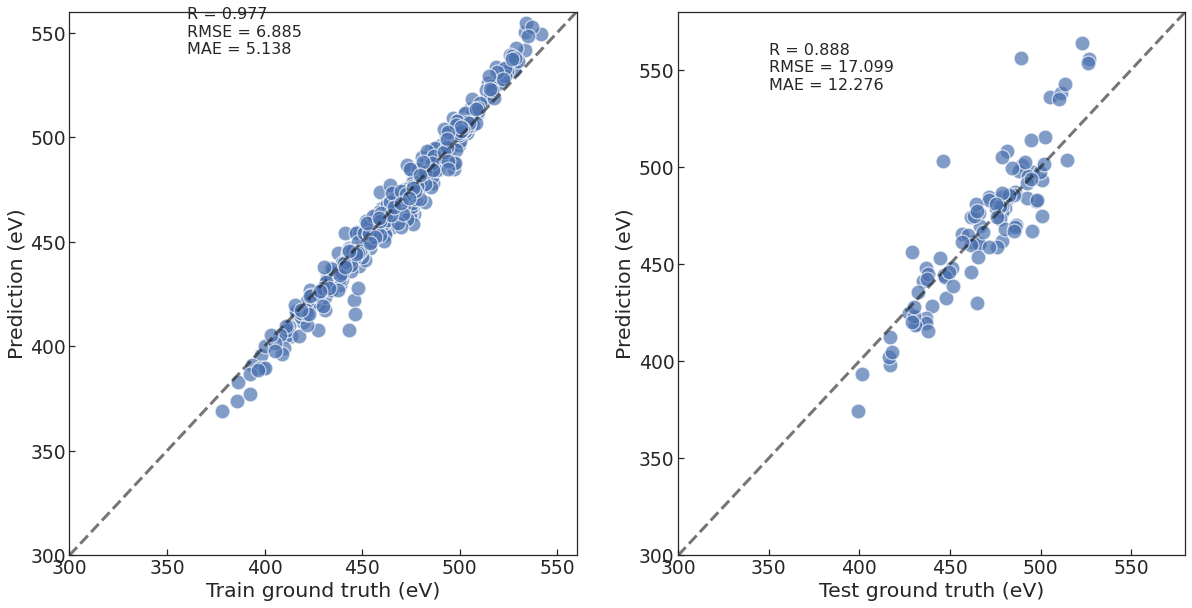

In [172]:
estimator = RandomForestRegressor(n_estimators=100, random_state=1)
df_modulus_ovp = calc_obs_vs_pred(X, y, estimator=estimator)

plot_obs_vs_pred(df_modulus_ovp)

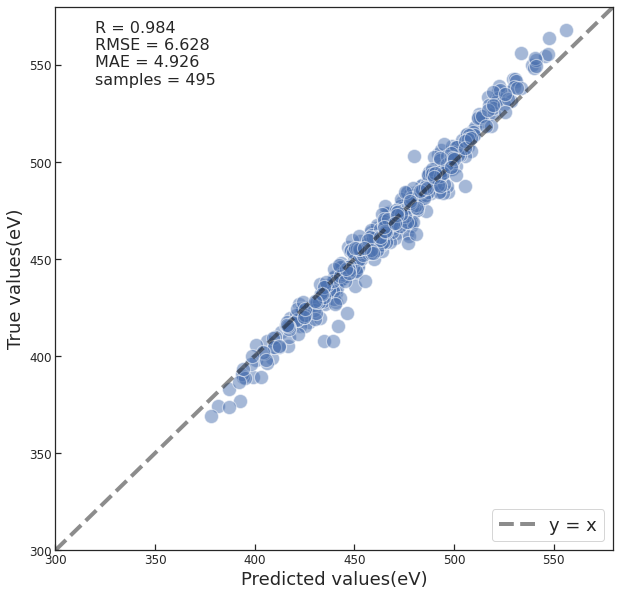

In [239]:
calc_pred_curve(X, y)


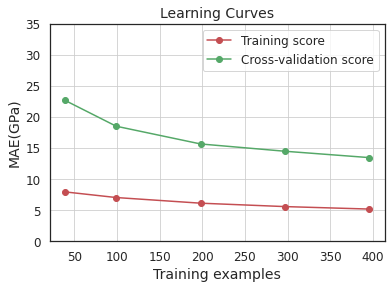

In [250]:
## learning-curve
estimator = RandomForestRegressor(n_estimators=100, random_state=1)
df_x1_lc = calc_learning_curve(X, y, estimator)

[Text(0.5, 0, ' '), Text(0, 0.5, 'Importance (%)')]

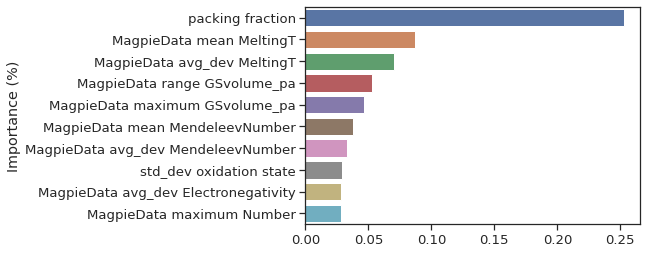

In [247]:
#Feature by importances
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X, y)
importances = rf.feature_importances_
df_import = pd.DataFrame()
included = x.columns.values
indices = np.argsort(importances)[::-1]

df_import["x"]=included[indices][0:10]
df_import["y"]=importances[indices][0:10]
ax= plt.subplots()
sns.set(style="white")
p = sns.barplot(x="y", y="x",data = df_import)
p.set( xlabel = " ", ylabel = 'Importance (%)')

In [ ]:
os.chdir('/home/zhaoxi/elastic_HEC/struct_no_Si/struct_no_Si_2')

In [119]:
vasp_list=os.listdir()[1:]
vasp_list.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list)

['1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp', '41.vasp', '42.vasp', '43.vasp', '44.vasp', '45.vasp', '46.vasp', '47.vasp', '48.vasp', '49.vasp', '50.vasp', '51.vasp', '52.vasp', '53.vasp', '54.vasp', '55.vasp', '56.vasp', '57.vasp', '58.vasp', '59.vasp', '60.vasp', '61.vasp', '62.vasp', '63.vasp', '64.vasp', '66.vasp', '67.vasp', '68.vasp', '69.vasp', '70.vasp', '71.vasp', '72.vasp', '73.vasp', '74.vasp', '75.vasp', '76.vasp', '77.vasp', '78.vasp', '79.vasp', '80.vasp', '81.vasp', '82.vasp', '83.vasp', '84.vasp', '85.vasp', '86.vasp', '87.vasp', '88.vasp', '89.vasp', '90.vasp', '91.vasp', '92.vasp', '93.vas

In [124]:
structs_125 = []
modulus_125 = []
for i in vasp_list:
    structs_125.append(Structure.from_file(i))
    with open(i) as f:
        lines = f.readlines()
        modulus_125.append(float(lines[0].split('|')[4]))

In [126]:
df_modulus_125 = pd.DataFrame()
formula_125=[]
for i in structs_125:
    formula_125.append(i.formula)
df_modulus_125["formula"]=formula_125
df_modulus_125["structure"]=structs_125
df_modulus_125["calc_modulus"]=modulus_125

In [127]:
df_modulus_125  ## 不含Si的125个四元非等比HEC

formula                                          structure  \
0    Hf1 Zr2 Ta4 Nb1 C8  [[0.         2.27510025 0.        ] C, [4.5523...   
1    Hf1 Zr2 Ta4 Ti1 C8  [[0.         2.26730797 0.        ] C, [4.5418...   
2    Hf1 Zr2 Ta4 Mo1 C8  [[0.         2.26534604 0.        ] C, [4.5433...   
3     Hf1 Zr2 Ta4 W1 C8  [[0.         2.26394747 0.        ] C, [4.5398...   
4    Hf1 Zr2 Ta4 Cr1 C8  [[0.         2.25929733 0.        ] C, [4.5235...   
..                  ...                                                ...   
119   Ti2 Nb4 Mo1 W1 C8  [[0.         2.20795065 0.        ] C, [4.4159...   
120  Ti2 Nb4 Cr1 Mo1 C8  [[0.        2.1975526 0.       ] C, [4.3775795...   
121   Ti2 Nb4 Cr1 W1 C8  [[0.         2.19677709 0.        ] C, [4.3754...   
122   Nb4 Cr1 Mo2 W1 C8  [[0.         2.20289974 0.        ] C, [4.3993...   
123   Ti4 Cr1 Mo2 W1 C8  [[0.         2.16145157 0.        ] C, [4.3070...   

     calc_modulus  
0         476.092  
1         454.302  
2         490.162  
3         501.315  
4         470.419  
..            ...  
119       531.087  
120       488.367  
121       497.787  
122       444.090  
123       483.466  

[124 rows x 3 columns]

## 125种非等比数据预测

In [203]:
os.chdir('/home/zhaoxi/elastic_HEC/struct_no_Si/struct_no_Si_2')

In [204]:
vasp_list=os.listdir()[0:]
vasp_list.sort(key = lambda x:int(x[:-5]))  #顺序排列文件
print(vasp_list)

['0.vasp', '1.vasp', '2.vasp', '3.vasp', '4.vasp', '5.vasp', '6.vasp', '7.vasp', '8.vasp', '9.vasp', '10.vasp', '11.vasp', '12.vasp', '13.vasp', '14.vasp', '15.vasp', '16.vasp', '17.vasp', '18.vasp', '19.vasp', '20.vasp', '21.vasp', '22.vasp', '23.vasp', '24.vasp', '25.vasp', '26.vasp', '27.vasp', '28.vasp', '29.vasp', '30.vasp', '31.vasp', '32.vasp', '33.vasp', '34.vasp', '35.vasp', '36.vasp', '37.vasp', '38.vasp', '39.vasp', '40.vasp', '41.vasp', '42.vasp', '43.vasp', '44.vasp', '45.vasp', '46.vasp', '47.vasp', '48.vasp', '49.vasp', '50.vasp', '51.vasp', '52.vasp', '53.vasp', '54.vasp', '55.vasp', '56.vasp', '57.vasp', '58.vasp', '59.vasp', '60.vasp', '61.vasp', '62.vasp', '63.vasp', '64.vasp', '66.vasp', '67.vasp', '68.vasp', '69.vasp', '70.vasp', '71.vasp', '72.vasp', '73.vasp', '74.vasp', '75.vasp', '76.vasp', '77.vasp', '78.vasp', '79.vasp', '80.vasp', '81.vasp', '82.vasp', '83.vasp', '84.vasp', '85.vasp', '86.vasp', '87.vasp', '88.vasp', '89.vasp', '90.vasp', '91.vasp', '92.vasp

In [205]:
len(vasp_list)

125

In [206]:
structs_125 = []
modulus_125 = []
for i in vasp_list:
    structs_125.append(Structure.from_file(i))
    with open(i) as f:
        lines = f.readlines()
        modulus_125.append(float(lines[0].split('|')[4]))

In [207]:
df_modulus_125 = pd.DataFrame()
formula_125=[]
for i in structs_125:
    formula_125.append(i.formula)
df_modulus_125["formula"]=formula_125
df_modulus_125["structure"]=structs_125
df_modulus_125["calc_modulus"]=modulus_125

In [208]:
df_modulus_125

formula                                          structure  \
0     Hf1 Zr2 Ta4 V1 C8  [[0.         2.26079136 0.        ] C, [4.5300...   
1    Hf1 Zr2 Ta4 Nb1 C8  [[0.         2.27510025 0.        ] C, [4.5523...   
2    Hf1 Zr2 Ta4 Ti1 C8  [[0.         2.26730797 0.        ] C, [4.5418...   
3    Hf1 Zr2 Ta4 Mo1 C8  [[0.         2.26534604 0.        ] C, [4.5433...   
4     Hf1 Zr2 Ta4 W1 C8  [[0.         2.26394747 0.        ] C, [4.5398...   
..                  ...                                                ...   
120   Ti2 Nb4 Mo1 W1 C8  [[0.         2.20795065 0.        ] C, [4.4159...   
121  Ti2 Nb4 Cr1 Mo1 C8  [[0.        2.1975526 0.       ] C, [4.3775795...   
122   Ti2 Nb4 Cr1 W1 C8  [[0.         2.19677709 0.        ] C, [4.3754...   
123   Nb4 Cr1 Mo2 W1 C8  [[0.         2.20289974 0.        ] C, [4.3993...   
124   Ti4 Cr1 Mo2 W1 C8  [[0.         2.16145157 0.        ] C, [4.3070...   

     calc_modulus  
0         474.384  
1         476.092  
2         454.302  
3         490.162  
4         501.315  
..            ...  
120       531.087  
121       488.367  
122       497.787  
123       444.090  
124       483.466  

[125 rows x 3 columns]

### 125种数据预测

In [82]:
test_125=data_process(df_modulus_125)

StrToComposition:   0%|          | 0/124 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/124 [00:00<?, ?it/s]

CompositionToOxidComposition:   0%|          | 0/124 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/124 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/124 [00:00<?, ?it/s]

In [83]:
excluded = ["formula", "structure","composition","composition_oxid","calc_modulus"]
x_t=test_125.drop(excluded,axis=1)

In [86]:
scaler = StandardScaler()
scaler.fit(x_t)
X_t = scaler.transform(x_t)

In [93]:
df_modulus_125["pred_modulus"] = rf.predict(X_t)

In [222]:
df_modulus_125

formula                                          structure  \
0     Hf1 Zr2 Ta4 V1 C8  [[0.         2.26079136 0.        ] C, [4.5300...   
1    Hf1 Zr2 Ta4 Nb1 C8  [[0.         2.27510025 0.        ] C, [4.5523...   
2    Hf1 Zr2 Ta4 Ti1 C8  [[0.         2.26730797 0.        ] C, [4.5418...   
3    Hf1 Zr2 Ta4 Mo1 C8  [[0.         2.26534604 0.        ] C, [4.5433...   
4     Hf1 Zr2 Ta4 W1 C8  [[0.         2.26394747 0.        ] C, [4.5398...   
..                  ...                                                ...   
120   Ti2 Nb4 Mo1 W1 C8  [[0.         2.20795065 0.        ] C, [4.4159...   
121  Ti2 Nb4 Cr1 Mo1 C8  [[0.        2.1975526 0.       ] C, [4.3775795...   
122   Ti2 Nb4 Cr1 W1 C8  [[0.         2.19677709 0.        ] C, [4.3754...   
123   Nb4 Cr1 Mo2 W1 C8  [[0.         2.20289974 0.        ] C, [4.3993...   
124   Ti4 Cr1 Mo2 W1 C8  [[0.         2.16145157 0.        ] C, [4.3070...   

     calc_modulus  
0         474.384  
1         476.092  
2         454.302  
3         490.162  
4         501.315  
..            ...  
120       531.087  
121       488.367  
122       497.787  
123       444.090  
124       483.466  

[125 rows x 3 columns]

(300.0, 600.0)

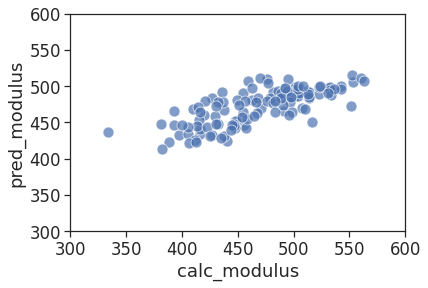

In [99]:
sns.set(style="ticks",font_scale=1.5)
axs = sns.scatterplot(data=df_modulus_125, x= "calc_modulus", y="pred_modulus",s=120,marker='o',alpha = 0.7, color = 'b')

axs.set_xlim(300,600)
axs.set_ylim(300,600)

In [128]:
df_modulus_125.describe()

calc_modulus
count    124.000000
mean     469.455605
std       45.539779
min      333.892000
25%      434.326500
50%      473.210000
75%      502.943500
max      562.887000

In [226]:
df_modulus_125.loc[65]

formula                                         Hf2 Zr4 Ti1 W1 C8
structure       [[0.         2.30508121 0.        ] C, [4.5848...
calc_modulus                                              447.378
Name: 65, dtype: object

In [ ]:
#### 疑似问题数据（76）
Read Elastic Constants from the ELASTIC_TENSOR.in file if it exists. （77）
   498.5458   111.6905   126.6280     0.0000     0.0000     0.0000
   111.6905   486.6227   115.8691     0.0000     0.0000     0.0000
   126.6280   115.8691   415.7834     0.0000     0.0000     0.0000
     0.0000     0.0000     0.0000   137.8247     0.0000     0.0000
     0.0000     0.0000     0.0000     0.0000    72.2849     0.0000
     0.0000     0.0000     0.0000     0.0000     0.0000   137.8531


In [ ]:
Read Elastic Constants from the ELASTIC_TENSOR.in file if it exists.  (79)
   498.9132   112.6138   124.3709     0.0000     0.0000     0.0000
   112.6138   515.4728   117.0108     0.0000     0.0000     0.0000
   124.3709   117.0108   509.4520     0.0000     0.0000     0.0000
     0.0000     0.0000     0.0000   157.1467     0.0000     0.0000
     0.0000     0.0000     0.0000     0.0000   129.8494     0.0000
     0.0000     0.0000     0.0000     0.0000     0.0000   130.7287

In [230]:
#### 修正数据
df_modulus_115 = df_modulus_125.drop(df_modulus_125.index[70:80])

In [231]:
df_modulus_115

formula                                          structure  \
0     Hf1 Zr2 Ta4 V1 C8  [[0.         2.26079136 0.        ] C, [4.5300...   
1    Hf1 Zr2 Ta4 Nb1 C8  [[0.         2.27510025 0.        ] C, [4.5523...   
2    Hf1 Zr2 Ta4 Ti1 C8  [[0.         2.26730797 0.        ] C, [4.5418...   
3    Hf1 Zr2 Ta4 Mo1 C8  [[0.         2.26534604 0.        ] C, [4.5433...   
4     Hf1 Zr2 Ta4 W1 C8  [[0.         2.26394747 0.        ] C, [4.5398...   
..                  ...                                                ...   
120   Ti2 Nb4 Mo1 W1 C8  [[0.         2.20795065 0.        ] C, [4.4159...   
121  Ti2 Nb4 Cr1 Mo1 C8  [[0.        2.1975526 0.       ] C, [4.3775795...   
122   Ti2 Nb4 Cr1 W1 C8  [[0.         2.19677709 0.        ] C, [4.3754...   
123   Nb4 Cr1 Mo2 W1 C8  [[0.         2.20289974 0.        ] C, [4.3993...   
124   Ti4 Cr1 Mo2 W1 C8  [[0.         2.16145157 0.        ] C, [4.3070...   

     calc_modulus  
0         474.384  
1         476.092  
2         454.302  
3         490.162  
4         501.315  
..            ...  
120       531.087  
121       488.367  
122       497.787  
123       444.090  
124       483.466  

[115 rows x 3 columns]

In [232]:
test_115=data_process(df_modulus_115)

excluded = ["formula", "structure","composition","composition_oxid","calc_modulus"]
x_t_115=test_115.drop(excluded,axis=1)



StrToComposition:   0%|          | 0/115 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/115 [00:00<?, ?it/s]

CompositionToOxidComposition:   0%|          | 0/115 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/115 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/115 [00:00<?, ?it/s]

In [233]:
X_t_115 = scaler.transform(x_t_115)

df_modulus_115["pred_modulus"] = rf.predict(X_t_115)

(310.0, 610.0)

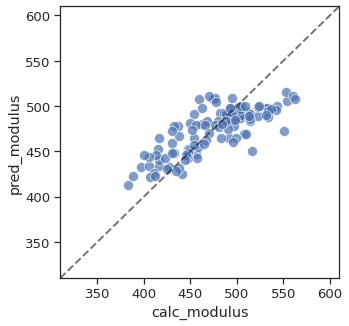

In [ ]:
f,axs= plt.subplots(figsize = (5, 5))
sns.set(style="ticks",font_scale=1.2)

formatXy = 'y = x'

axs = sns.scatterplot(data=df_modulus_115, x= "calc_modulus", y="pred_modulus",s=100,marker='o',alpha = 0.7, color = 'b')
axs.plot((0, 1.2),(0, 1.2), transform=axs.transAxes, linewidth=2, ls='--',c='k',alpha=0.6, label = formatXy)
axs.set_xlim(310,610)
axs.set_ylim(310,610)

In [255]:
df_modulus_115

formula                                          structure  \
0     Hf1 Zr2 Ta4 V1 C8  [[0.         2.26079136 0.        ] C, [4.5300...   
1    Hf1 Zr2 Ta4 Nb1 C8  [[0.         2.27510025 0.        ] C, [4.5523...   
2    Hf1 Zr2 Ta4 Ti1 C8  [[0.         2.26730797 0.        ] C, [4.5418...   
3    Hf1 Zr2 Ta4 Mo1 C8  [[0.         2.26534604 0.        ] C, [4.5433...   
4     Hf1 Zr2 Ta4 W1 C8  [[0.         2.26394747 0.        ] C, [4.5398...   
..                  ...                                                ...   
120   Ti2 Nb4 Mo1 W1 C8  [[0.         2.20795065 0.        ] C, [4.4159...   
121  Ti2 Nb4 Cr1 Mo1 C8  [[0.        2.1975526 0.       ] C, [4.3775795...   
122   Ti2 Nb4 Cr1 W1 C8  [[0.         2.19677709 0.        ] C, [4.3754...   
123   Nb4 Cr1 Mo2 W1 C8  [[0.         2.20289974 0.        ] C, [4.3993...   
124   Ti4 Cr1 Mo2 W1 C8  [[0.         2.16145157 0.        ] C, [4.3070...   

     calc_modulus  
0         474.384  
1         476.092  
2         454.302  
3         490.162  
4         501.315  
..            ...  
120       531.087  
121       488.367  
122       497.787  
123       444.090  
124       483.466  

[115 rows x 3 columns]